In [1]:
import pandas as pd
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from pathlib import Path
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime
import re
from scipy import stats
from scipy.optimize import curve_fit
import numpy as np
import statsmodels.api as sm
from matplotlib import colormaps
from tqdm.notebook import tqdm
import helpers
from sklearn.metrics import r2_score
from IPython.display import clear_output

from mri_data import file_manager as fm

## Load Data

To clarify my confusion about the bootstrapping procedure

I was confusing two things: bootstrapping the regression normally would involve selecting observations from the structure's beta's with replacement 1000 times. That definitely would not be significant, clearly.

What I am actually doing it reproducing the structures' betas 1000 times by resampling from the cohort. This is telling us something about the stability of the final line (structure betas vs distance), which may or may not be significant. 

Still something that's confusing: one procedure is to compare all the bootstrapped t_stats to the t_stat of the actual line to see how many of the bootstrapped ones were more extreme. The other is to compare them to zero. If it's invalid/uninformative to compare them to zero, it also means it's uninformative to compare them to the t_stat of another line (like the NIND line). Need to figure this out. 
- Note that doing the procedure with OIND and comparing all the t_stats to zero gives a p value of 0.072 (PMS p=0.078). So this may be valid and not something that'll always just be significant 
  - So the question is: what exactly is the p value showing is significant? That there is some amount of positive gradient? That's what the p value of the original line also tells you. **Maybe the difference is that we have more statistical power than the simple singular regression can harness, and bootstrapping over the cohort harnesses it?**
  - Since I'm comparing to 0, the p value is just telling us whether we can conclude that the slope is greater than 0. The p value for the singular regression maybe tells us whether we can conclude that the slope is as much as what it is
- Double check where I found the procedure that said compare the t_stats to the actual data's t_stat, and see what that procedure was meant to be applied to.

In [2]:
drive_root = fm.get_drive_root()
dataroot = drive_root / "3Tpioneer_bids"
data_dir = Path("/home/srs-9/Projects/ms_mri/data")
fig_path = Path("/home/srs-9/Projects/ms_mri/analysis/thalamus/figures_tables/gradient_analysis")

choroid_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/choroid_aschoplex_volumes.csv", index_col="subid"
)
ventricle_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/paper1/data0/ventricle_volumes.csv",
    index_col="subid",
)
tiv = pd.read_csv("/home/srs-9/Projects/ms_mri/data/tiv_data.csv", index_col="subid")

df = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/clinical_data_processed.csv", index_col="subid"
)
sdmt = pd.read_csv("/home/srs-9/Projects/ms_mri/analysis/thalamus/SDMT_sheet.csv", index_col="subid")
df = df.join([choroid_volumes, ventricle_volumes, tiv, sdmt['SDMT']])
df['SDMT'] = pd.to_numeric(df['SDMT'], errors='coerce')
df['thalamus_sqrt'] = np.sqrt(df['thalamus'])
df['thalamus_curt'] = np.sqrt(df['thalamus']**3)
df['cortical_thickness_inv'] = 1 / df['cortical_thickness']
df_z = df.copy()
numeric_cols = df.select_dtypes(include='number').columns
df_z[numeric_cols] = df_z[numeric_cols].apply(stats.zscore, nan_policy="omit")

viridis = colormaps['viridis'].resampled(20)

colors = helpers.get_colors()

In [3]:
df_thomas = pd.read_csv(data_dir / "hipsthomas_vols.csv", index_col="subid")
cols_orig = df_thomas.columns
new_colnames = {}
for col in df_thomas.columns:
    new_col = re.sub(r"(\d+)-([\w-]+)", r"\2_\1", col)
    new_col = re.sub("-", "_", new_col)
    new_colnames[col] = new_col
df_thomas = df_thomas.rename(columns=new_colnames)
df_thomas_norm = df_thomas.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas_z = df_thomas.apply(stats.zscore, nan_policy="omit")
df_thomas_norm_z = df_thomas_norm.apply(stats.zscore, nan_policy="omit")

df_thomas_left = pd.read_csv(data_dir / "hipsthomas_left_vols.csv", index_col="subid")
df_thomas_left = df_thomas_left.rename(columns=new_colnames)
df_thomas_left_z = df_thomas_left.apply(stats.zscore, nan_policy="omit")

df_thomas_right = pd.read_csv(data_dir / "hipsthomas_right_vols.csv", index_col="subid")
df_thomas_right = df_thomas_right.rename(columns=new_colnames)
df_thomas_right_z = df_thomas_right.apply(stats.zscore, nan_policy="omit")


thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
ignore_structs1 = ["THALAMUS_1", "Amy_34", "GP_33", "Cla_28", "Acc_26", "Hb_13", "MTT_14"]
ignore_structs2 = ["THALAMUS_1", "Amy_34", "GP_33", "Hb_13", "MTT_14"]

thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)['struct']
hips_thomas_invref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="struct"
)['index']
# hips_thomas_ref.rename(columns={"struct": "struct_name"}, inplace=True)

choroid_dists_left = pd.read_csv(data_dir / "centroid-choroid_centroid-left.csv", index_col="subid")
choroid_dists_right = pd.read_csv(data_dir / "centroid-choroid_centroid-right.csv", index_col="subid")
choroid_dists = (choroid_dists_left + choroid_dists_right) / 2
mean_choroid_dists = choroid_dists.mean()
new_index = [int(ind) for ind in mean_choroid_dists.index]
mean_choroid_dists.index = new_index

ventricle_dists_sdt_left = pd.read_csv(
    data_dir / "centroid-ventricle_SDT-left.csv", index_col="subid"
)
ventricle_dists_sdt_right = pd.read_csv(
    data_dir / "centroid-ventricle_SDT-right.csv", index_col="subid"
)
ventricle_dists_sdt = (ventricle_dists_sdt_right + ventricle_dists_sdt_left) / 2

mean_ventricle_dists_sdt = ventricle_dists_sdt.mean()
new_index = [int(ind) for ind in mean_ventricle_dists_sdt.index]
mean_ventricle_dists_sdt.index = new_index


ventricle_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/data/centroid-ventricle_centroid-left.csv", index_col='subid')
mean_ventricle_dists = ventricle_dists.mean()
new_index = [int(ind) for ind in mean_ventricle_dists.index]
mean_ventricle_dists.index = new_index

mni_choroid_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni-centroid-choroid_SDT2.csv")

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pandas/core/apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)


From `compute_exposures2.py`. This is what we want:

In [4]:
# mni_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni_centroid_centroid_dists.csv", index_col="index")
mni_dists2 = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni_choroid_struct_SDT.csv", index_col="index")
mni_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni_centroid_centroid_dists.csv",
                                index_col="index")

mni_dists['struct'] = hips_thomas_ref
# mni_ventricle_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni_ventricle_exposures3.csv", index_col="index")
mni_ventricle_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni_ventricle_centroid_centroid_dists.csv", index_col="index")
mni_ventricle_dists['struct'] = hips_thomas_ref

# choroid_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/data/centroid-choroid_centroid.csv", index_col="subid")

## Functions

In [5]:
def regress_all_nuclei(model_data, covariates, outcome, structs):
    pvals = {}
    coefs = {}
    se = {}

    if len(covariates) > 0:
        plus_covariates = f"+ {covariates}"
    else:
        plus_covariates = ""
    all_results = {}
    for struct in structs:
        formula = f"{outcome} ~ {struct} {plus_covariates}"
        res = sm.OLS.from_formula(formula, data=model_data).fit()
        pvals[struct] = res.pvalues[struct]
        coefs[struct] = res.params[struct]
        se[struct] = res.HC0_se[struct]
        all_results[struct] = res

    regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals, "se": se})
    regression_results['p_fdr'] = stats.false_discovery_control(
        regression_results['pvals'], method='bh'
    )
    # regression_results = regression_results.sort_values(by="coef", ascending=True)
    regression_results.insert(0, "struct", regression_results.index)
    new_index = []
    for item in regression_results.struct:
        new_index.append(int(re.match(r".+_(\d+)$", item)[1]))

    for i, row in regression_results.iterrows():
        if row['p_fdr'] < 0.05:
            regression_results.loc[i, 'coef_sig'] = row['coef']
        else:
            regression_results.loc[i, 'coef_sig'] = 0

    regression_results.index = new_index
    return regression_results

def regress_all_nuclei2(model_data, covariates, pred, structs):
    pvals = {}
    coefs = {}
    se = {}

    if len(covariates) > 0:
        plus_covariates = f"+ {covariates}"
    else:
        plus_covariates = ""
    all_results = {}
    for struct in structs:
        formula = f"{struct} ~ {pred} {plus_covariates}"
        res = sm.OLS.from_formula(formula, data=model_data).fit()
        pvals[struct] = res.pvalues[pred]
        coefs[struct] = res.params[pred]
        se[struct] = res.HC0_se[pred]
        all_results[struct] = res

    regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals, "se": se})
    regression_results['p_fdr'] = stats.false_discovery_control(
        regression_results['pvals'], method='bh'
    )
    # regression_results = regression_results.sort_values(by="coef", ascending=True)
    regression_results.insert(0, "struct", regression_results.index)
    new_index = []
    for item in regression_results.struct:
        new_index.append(int(re.match(r".+_(\d+)$", item)[1]))

    for i, row in regression_results.iterrows():
        if row['p_fdr'] < 0.05:
            regression_results.loc[i, 'coef_sig'] = row['coef']
        else:
            regression_results.loc[i, 'coef_sig'] = 0

    regression_results.index = new_index
    return regression_results


def plot_xordered_data(
    data, x_name, y_name, label_name, loc=(0.8, 0.05), fit_line=False, fdr=False,
    xlabel=None, ylabel=None, title=None, axes=None, fig=None, legend=False,
    fit_params=True, hide_x=False, fontsize=12
):
    if fdr:
        p_col = "p_fdr"
    else:
        p_col = "pvals"

    if xlabel is None:
        xlabel = x_name
    if ylabel is None:
        ylabel = y_name
    if title is None:
        title = f"{ylabel} vs {xlabel}"

    if axes is None:
        fig, axes = plt.subplots(1)
    data.sort_values(by=x_name, inplace=True)
    for i, row in data.iterrows():
        c = row[x_name] / data[x_name].max()
        if p_col in data.columns and data.loc[i, p_col] >= 0.05:
            marker = "x"
        else:
            marker = "D"
        if legend:
            label = data.loc[i, label_name]
        else:
            label = None
        axes.scatter(
            data.loc[i, x_name],
            data.loc[i, y_name],
            marker=marker,
            color=viridis(c),
            label=label,
        )

    xlims = axes.get_xlim()
    ylims = axes.get_ylim()

    slope, intercept, r_value, p_value, std_err = stats.linregress(
            data[x_name], data[y_name])
    if fit_line:
        x = np.array([xlims[0], xlims[1]])
        y = slope * x + intercept
        axes.plot(x, y, c='black')
    
    if fit_params:
        text = "R2={:0.2f}\np={:0.2f}".format(r_value**2, p_value)
        text_y = ylims[0] + (ylims[1] - ylims[0]) * 0.9
        text_x = xlims[0] + (xlims[1] - xlims[0]) * 0.05
        axes.text(text_x, text_y, text, fontsize=fontsize)

    axes.set_xbound([xlims[0], xlims[1] * 1.1])
    if legend:
        fig.legend(loc=loc)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_title(title)
    if hide_x:
        axes.xaxis.set_major_formatter(plt.NullFormatter())
        axes.set_xlabel("")

    return fig, axes

def plot_xordered_data_ignore_nonsig(
    data, x_name, y_name, label_name, loc=(0.8, 0.05), fit_line=False, fdr=False,
    xlabel=None, ylabel=None, title=None, axes=None, fig=None, legend=False
):
    if fdr:
        p_col = "p_fdr"
    else:
        p_col = "pvals"

    if xlabel is None:
        xlabel = x_name
    if ylabel is None:
        ylabel = y_name
    if title is None:
        title = f"{ylabel} vs {xlabel}"

    if axes is None:
        fig, axes = plt.subplots(1)
    data.sort_values(by=x_name, inplace=True)
    data = data[data[p_col] < 0.05]
    for i, row in data.iterrows():
        c = row[x_name] / data[x_name].max()
        if p_col in data.columns and data.loc[i, p_col] >= 0.05:
            marker = "x"
        else:
            marker = "D"
        if legend:
            label = data.loc[i, label_name]
        else:
            label = None
        axes.scatter(
            data.loc[i, x_name],
            data.loc[i, y_name],
            marker=marker,
            color=viridis(c),
            label=label,
        )

    xlims = axes.get_xlim()
    ylims = axes.get_ylim()

    if fit_line:
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            data[x_name], data[y_name]
        )
        x = np.array([xlims[0], xlims[1]])
        y = slope * x + intercept
        axes.plot(x, y, c='black')
        text = "R2={:0.2f}\np={:0.2f}".format(r_value**2, p_value)
        text_y = ylims[0] + (ylims[1] - ylims[0]) * 0.9
        text_x = xlims[0] + (xlims[1] - xlims[0]) * 0.05
        axes.text(text_x, text_y, text)

    axes.set_xbound([xlims[0], xlims[1] * 1.1])
    if legend:
        fig.legend(loc=loc)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_title(title)

    return fig, axes

def bootstrap_procedure(model_data, distances, covariates, outcome, structs, n_boots=1000, inverse_slope=False):
    df_to_sample = model_data.copy() # copy over the model_data from above
    df_to_sample = df_to_sample.reset_index()

    n_boots = 1000
    t_stats = np.zeros((n_boots,))
    slopes = np.zeros((n_boots,))
    r_values = np.zeros((n_boots,))
    for i_samp in tqdm(range(n_boots)):
        inds = np.random.randint(0, df_to_sample.index.max(), len(df_to_sample))
        model_data = df_to_sample.loc[inds, :]

        regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)
        data = regression_results.copy()
        data['dist'] = distances
        slope, intercept, r_value, p_value, std_err = stats.linregress(data['dist'], data['coef'])
        t_stats[i_samp] = (slope / std_err)
        slopes[i_samp] = slope
        r_values[i_samp] = r_value

    # slopes.sort()
    # mean_slope = slopes.mean()
    # print("Slope: {:0.2} [{:0.2}, {:0.2}]".format(mean_slope, slopes[25], slopes[975]))

    # r_values.sort()
    # mean_r_value = r_values.mean()
    # print("R2: {:0.2} [{:0.2}, {:0.2}]".format(mean_r_value**2, r_values[25]**2, r_values[975]**2))

    if inverse_slope:
        p_boot = sum(t_stats >= 0) / n_boots
    else:
        p_boot = sum(t_stats <= 0) / n_boots
    # print("Bootstrapped p: {:0.2f}".format(p_boot))
    return slopes, r_values, p_boot

def bootstrap_procedure2(model_data, all_distances, covariates, predictor, structs, n_boots=1000, inverse_slope=False):
    df_to_sample = model_data.join(all_distances)
    df_to_sample = df_to_sample.reset_index()
    struct_i = hips_thomas_invref[structs]
    struct_str = [str(i) for i in struct_i]

    n_boots = 1000
    t_stats = np.zeros((n_boots,))
    slopes = np.zeros((n_boots,))
    intercepts = np.zeros((n_boots,))
    r_values = np.zeros((n_boots,))
    for i_samp in tqdm(range(n_boots)):
        inds = np.random.randint(0, df_to_sample.index.max(), len(df_to_sample))
        model_data = df_to_sample.loc[inds, :]
        distances = model_data[struct_str].mean()
        new_index = [int(ind) for ind in distances.index]
        distances.index = new_index
        regression_results = regress_all_nuclei2(model_data, covariates, predictor, structs)
        data = regression_results.copy()
        data['dist'] = distances
        slope, intercept, r_value, p_value, std_err = stats.linregress(data['dist'], data['coef'])
        t_stats[i_samp] = (slope / std_err)
        slopes[i_samp] = slope
        r_values[i_samp] = r_value
        intercepts[i_samp] = intercept

    # slopes.sort()
    # mean_slope = slopes.mean()
    # print("Slope: {:0.2} [{:0.2}, {:0.2}]".format(mean_slope, slopes[25], slopes[975]))

    # r_values.sort()
    # mean_r_value = r_values.mean()
    # print("R2: {:0.2} [{:0.2}, {:0.2}]".format(mean_r_value**2, r_values[25]**2, r_values[975]**2))

    if inverse_slope:
        p_boot = sum(t_stats >= 0) / n_boots
    else:
        p_boot = sum(t_stats <= 0) / n_boots
    # print("Bootstrapped p: {:0.2f}".format(p_boot))
    return slopes, intercepts, r_values, p_boot


def saturation_curve(x, a, b, c):
    return a*(1-np.exp(-b*x)) - c


def geo_mean(x):
    return np.prod(x)**(1.0/len(x))

def balance(num, denom):
    return np.log(geo_mean(num)/geo_mean(denom))

def log_ratio(num, denom):
    return np.log(num / geo_mean(denom).T)

## Analysis

### For Cartoon Figure

#### Distances

In [5]:
dists_to_bin = mni_dists[~mni_dists.index.isin([1, 13, 14, 33, 34, 4567])]
dists_to_bin = mni_dists[mni_dists.index.isin(thalamic_nuclei)]

left_bins = np.linspace(dists_to_bin['left_exposure'].min(), dists_to_bin['left_exposure'].max(), 10)
dists_to_bin['left_bins'] = np.digitize(dists_to_bin['left_exposure'], left_bins)
right_bins = np.linspace(dists_to_bin['right_exposure'].min(), dists_to_bin['right_exposure'].max(), 10)
dists_to_bin['right_bins'] = np.digitize(dists_to_bin['right_exposure'], right_bins)
dists_to_bin.sort_values(by="left_bins")

,left_exposure,right_exposure,struct,left_bins,right_bins
index,,,,,
8,8.712833,8.349248,Pul_8,1,1
7,13.337370,12.456556,VPL_7,3,2
10,17.274308,16.610573,MGN_10,4,4
9,19.527532,18.583537,LGN_9,5,5
11,18.029122,17.492163,CM_11,5,5
6,20.982216,20.271701,VLP_6,6,6
12,20.743111,20.187040,MD_Pf_12,6,6
5,25.154024,24.134354,VLa_5,8,8
2,28.724859,28.201181,AV_2,9,9


In [60]:
distances = dists_to_bin.sort_values(by="left_exposure")[['struct', 'left_exposure']]
distances.to_excel(fig_path / "distances.xlsx")

#### Coefficients

In [7]:
model_data = df_z.join([df_thomas_left_z])
model_data = model_data[model_data['dz_type2'] == "MS"]
structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33"])]
structs = hips_thomas_ref[thalamic_nuclei]
covariates = "age + Female"
outcome = "choroid_volume"

regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)

bins = np.linspace(regression_results['coef'].min(), regression_results.coef.max(), 10)
regression_results['coef_bin'] = np.digitize(regression_results['coef'], bins)
regression_results.sort_values(by="coef")[['struct', 'coef_bin']]

,struct,coef_bin
8,Pul_8,1
12,MD_Pf_12,1
10,MGN_10,1
9,LGN_9,2
11,CM_11,3
2,AV_2,5
7,VPL_7,5
6,VLP_6,6
5,VLa_5,9
4,VA_4,10


In [8]:
model_data = df_z.join([df_thomas_right_z])
model_data = model_data[model_data['dz_type2'] == "MS"]
structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33"])]
structs = hips_thomas_ref[thalamic_nuclei]
covariates = "age + Female"
outcome = "choroid_volume"

regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)

bins = np.linspace(regression_results['coef'].min(), regression_results.coef.max(), 10)
regression_results['coef_bin'] = np.digitize(regression_results['coef'], bins)
regression_results.sort_values(by="coef")[['struct', 'coef_bin']]

,struct,coef_bin
12,MD_Pf_12,1
8,Pul_8,1
10,MGN_10,3
11,CM_11,3
9,LGN_9,4
2,AV_2,5
7,VPL_7,6
6,VLP_6,6
5,VLa_5,9
4,VA_4,10


### MS Patients

#### Exclude Far Structures

Claustrum, nucleus accumbens, amygdala

In [31]:
new_cols = {i: f"{hips_thomas_ref[int(i)]}_choroid_dist" for i in choroid_dists.columns}
model_data_cp_dists = choroid_dists.rename(columns=new_cols)
new_cols = {i: f"{hips_thomas_ref[int(i)]}_ventricle_dist" for i in ventricle_dists_sdt.columns}
model_data_v_dists = ventricle_dists_sdt.rename(columns=new_cols)

model_data = df_z.join([df_thomas_z, model_data_cp_dists, model_data_v_dists])
model_data = model_data[model_data['dz_type3'] == "MS"]

ind = 2
formula = f"{hips_thomas_ref[ind]} ~ choroid_volume + {hips_thomas_ref[ind]}_choroid_dist + {hips_thomas_ref[ind]}_ventricle_dist + age + Female + tiv"
res = sm.OLS.from_formula(formula, data=model_data).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   AV_2   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     42.09
Date:                Sat, 28 Jun 2025   Prob (F-statistic):           7.16e-41
Time:                        11:10:01   Log-Likelihood:                -540.94
No. Observations:                 465   AIC:                             1096.
Df Residuals:                     458   BIC:                             1125.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -3.3707    

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'MS\n struct ~ *choroid_volume* + age + Female + tiv + ventricle_volume'}, xlabel='ventricle_SDT_dist', ylabel='coef'>)

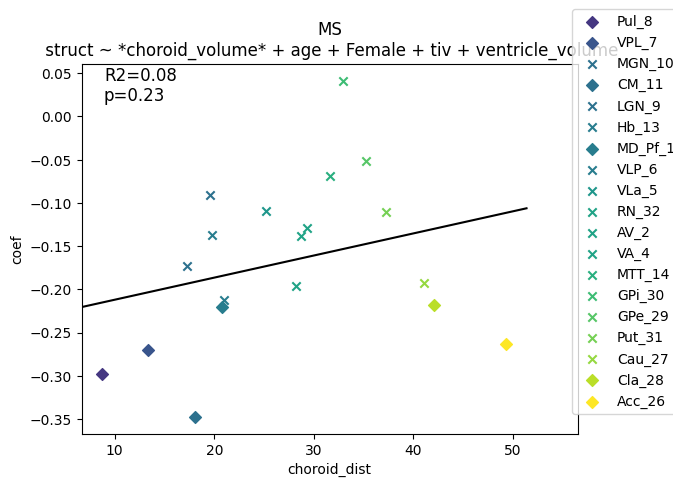

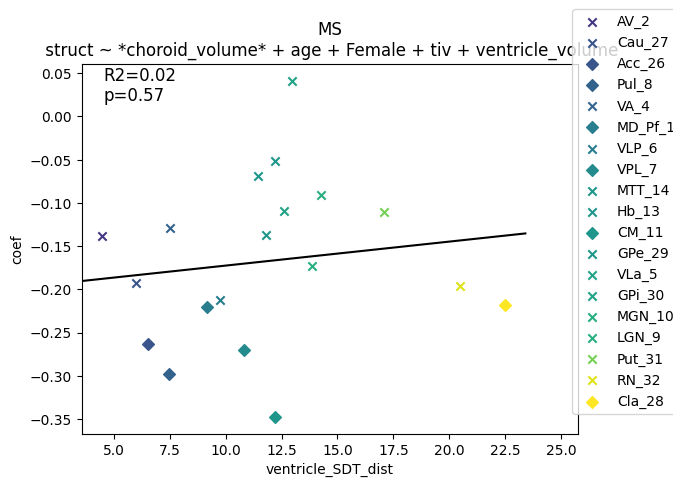

In [19]:
model_data = df_z.join([df_thomas_z])
model_data = model_data[model_data['dz_type5'] == "PMS"]
structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33"])]
# exclude_structs = hips_thomas_ref[thalamic_nuclei].tolist() + ["Amy_34", "GPi_30", "GPe_29"]
# structs = df_thomas.columns[~df_thomas.columns.isin(exclude_structs)]

predictor = "choroid_volume"
covariates = "age + Female + tiv + ventricle_volume"
regression_results = regress_all_nuclei2(model_data, covariates, predictor, structs)

data = regression_results.copy()
# data = regression_results[regression_results.pvals < 0.05]
# data['choroid_dist'] = mean_choroid_dists
data['choroid_dist'] = mni_dists['left_exposure']
data['ventricle_SDT_dist'] = mean_ventricle_dists_sdt

structs_to_use = data['struct']


# fig, axs = plt.subplots(1, 2, figsize=(16, 6))
fig, axs = plt.subplots()
plot_xordered_data(data, "choroid_dist", "coef", "struct", fit_line=True,
                    title=f"MS\n struct ~ *{predictor}* + {covariates}",
                    axes=axs, fig=fig, legend=True, loc=(0.85, 0.15), fdr=False)
# plt.savefig(fig_path / "choroid_correlations_all_structs_v_cp_dist.png", dpi=300)

fig, axs = plt.subplots()
plot_xordered_data(data, "ventricle_SDT_dist", "coef", "struct", fit_line=True,
                    title=f"MS\n struct ~ *{predictor}* + {covariates}",
                    axes=axs, fig=fig, legend=True, loc=(0.85, 0.15), fdr=False)
# plt.savefig(fig_path / "choroid_correlations_all_structs_v_ventricle_dist.png", dpi=300)


In [ ]:
# structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33"])]
structs = structs_to_use

all_slopes = []
all_r = []
all_p_boot = []
all_intercepts = []
# for distance in [choroid_dists, ventricle_dists_sdt]:
for distance in [choroid_dists]:
    slopes, intercepts, r_vals, p_boot = bootstrap_procedure2(model_data, distance, covariates, predictor, structs)
    
    all_slopes.append(slopes)
    all_r.append(r_vals)
    all_p_boot.append(p_boot)
    all_intercepts.append(intercepts)

clear_output(wait=True)

# for i, distance in enumerate([mni_dists['left_exposure'], mean_ventricle_dists_sdt]):
for i, distance in enumerate([mni_dists['left_exposure']]):
    r_values = all_r[i]
    r_values.sort()
    mean_r_value = r_values.mean()
    print("R2: {:0.2} [{:0.2}, {:0.2}]".format(mean_r_value**2, r_values[25]**2, r_values[975]**2))
    print("R2: {:0.2}".format(r_values[500]))
    p_boot = all_p_boot[i]
    print("Bootstrapped p: {:0.2f}".format(p_boot))
    print("---")

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyError: "None of [Index(['1', '13', '26', '27', '28', '31', '32'], dtype='object')] are in the [columns]"

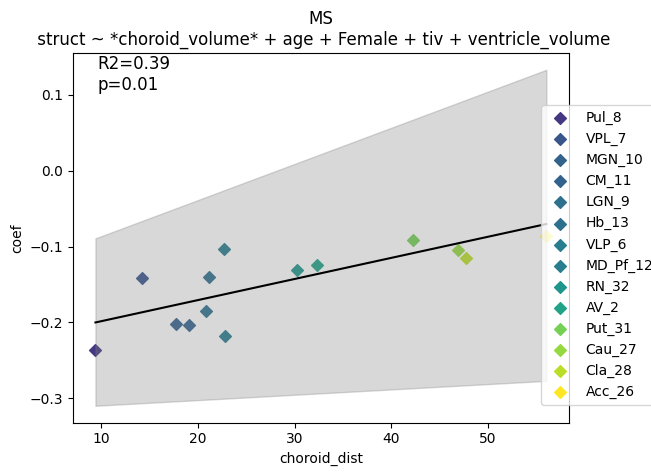

In [18]:
from statistics import mean

# structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33"])]
structs = structs_to_use
regression_results = regress_all_nuclei2(model_data, covariates, predictor, structs)
data = regression_results.copy()
data['choroid_dist'] = mean_choroid_dists
data['ventricle_SDT_dist'] = mean_ventricle_dists_sdt

i=0
x_range = np.linspace(data['choroid_dist'].min(), data['choroid_dist'].max())
fig, axs = plt.subplots()
slopes = all_slopes[i]
intercepts = all_intercepts[i]

sort_slopes = sorted(slopes)
sort_intercepts = sorted(intercepts)
y_low = sort_intercepts[25] + sort_slopes[25]*x_range
y_high = sort_intercepts[975] + sort_slopes[975]*x_range
y = mean(sort_intercepts) + mean(sort_slopes)*x_range

r2 = all_r[i].mean()**2
p = all_p_boot[i]

plot_xordered_data(data, "choroid_dist", "coef", "struct", fit_line=False,
                title=f"MS\n struct ~ *{predictor}* + {covariates}",
                axes=axs, fig=fig, legend=True, loc=(0.83, 0.15), fit_params=False)

axs.fill_between(x_range, y_low, y_high, alpha=0.3, color="gray")
axs.plot(x_range, y, color='black')
xlims = axs.get_xlim()
ylims = axs.get_ylim()
text = "R2={:0.2f}\np={:0.2f}".format(r2, p)
text_y = ylims[0] + (ylims[1] - ylims[0]) * 0.9
text_x = xlims[0] + (xlims[1] - xlims[0]) * 0.05
axs.text(text_x, text_y, text, fontsize=12)
plt.savefig(fig_path / "choroid_correlations_all_v_cp_dist_shading.png", dpi=300)

# i=1
# x_range = np.linspace(data['ventricle_SDT_dist'].min(), data['ventricle_SDT_dist'].max())
# fig, axs = plt.subplots()
# slopes = all_slopes[i]
# intercepts = all_intercepts[i]

# sort_slopes = sorted(slopes)
# sort_intercepts = sorted(intercepts)
# y_low = sort_intercepts[25] + sort_slopes[25]*x_range
# y_high = sort_intercepts[975] + sort_slopes[975]*x_range
# y = mean(sort_intercepts) + mean(sort_slopes)*x_range

# r2 = all_r[i].mean()**2
# p = all_p_boot[i]

# plot_xordered_data(data, "ventricle_SDT_dist", "coef", "struct", fit_line=False,
#                 title=f"MS\n struct ~ *{predictor}* + {covariates}",
#                 axes=axs, fig=fig, legend=True, loc=(0.83, 0.15), fit_params=False)

# axs.fill_between(x_range, y_low, y_high, alpha=0.3, color="gray")
# axs.plot(x_range, y, color='black')
# xlims = axs.get_xlim()
# ylims = axs.get_ylim()
# text = "R2={:0.2f}\np={:0.2f}".format(r2, p)
# text_y = ylims[0] + (ylims[1] - ylims[0]) * 0.9
# text_x = xlims[0] + (xlims[1] - xlims[0]) * 0.05
# axs.text(text_x, text_y, text, fontsize=12)

# plt.savefig(fig_path / "choroid_correlations_all_v_ventricle_dist_shading.png", dpi=300)

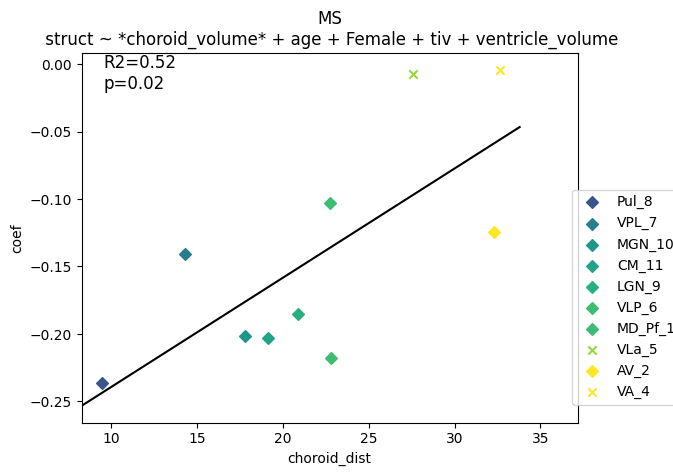

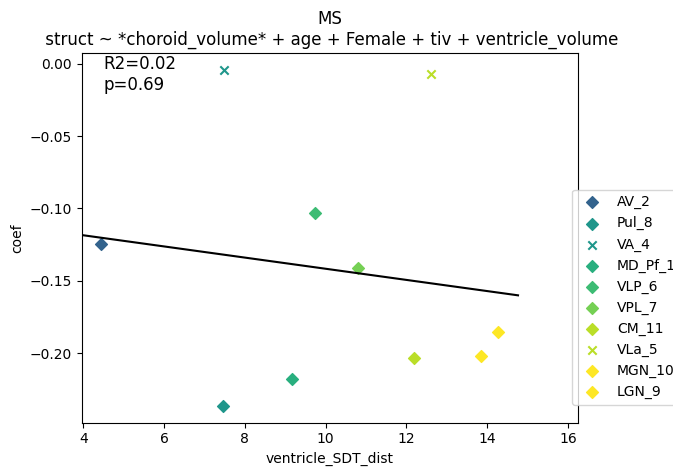

In [10]:
model_data = df_z.join([df_thomas_z])
model_data = model_data[model_data['dz_type3'] == "MS"]
structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33"])]
structs = hips_thomas_ref[thalamic_nuclei]

predictor = "choroid_volume"
covariates = "age + Female + tiv + ventricle_volume"
regression_results = regress_all_nuclei2(model_data, covariates, predictor, structs)

data = regression_results.copy()
# data = regression_results[regression_results.pvals < 0.05]
data['choroid_dist'] = mean_choroid_dists
data['ventricle_SDT_dist'] = mean_ventricle_dists_sdt


# fig, axs = plt.subplots(1, 2, figsize=(16, 6))
fig, axs = plt.subplots()
plot_xordered_data(data, "choroid_dist", "coef", "struct", fit_line=True,
                    title=f"MS\n struct ~ *{predictor}* + {covariates}",
                    axes=axs, fig=fig, legend=True, loc=(0.85, 0.15), fdr=False)
plt.savefig(fig_path / "choroid_correlations_thalamuc_nuclei_v_cp_dist.png", dpi=300)

fig, axs = plt.subplots()
plot_xordered_data(data, "ventricle_SDT_dist", "coef", "struct", fit_line=True,
                    title=f"MS\n struct ~ *{predictor}* + {covariates}",
                    axes=axs, fig=fig, legend=True, loc=(0.85, 0.15), fdr=False)
plt.savefig(fig_path / "choroid_correlations_thalamuc_nuclei_v_ventricle_dist.png", dpi=300)


In [45]:
structs = hips_thomas_ref[thalamic_nuclei]

all_slopes = []
all_r = []
all_p_boot = []
all_intercepts = []
for distance in [choroid_dists, ventricle_dists_sdt]:
    slopes, intercepts, r_vals, p_boot = bootstrap_procedure2(model_data, distance, covariates, predictor, structs)
    
    all_slopes.append(slopes)
    all_r.append(r_vals)
    all_p_boot.append(p_boot)
    all_intercepts.append(intercepts)

clear_output(wait=True)

for i, distance in enumerate([mni_dists['left_exposure'], mean_ventricle_dists_sdt]):
    r_values = all_r[i]
    r_values.sort()
    mean_r_value = r_values.mean()
    print("R2: {:0.2} [{:0.2}, {:0.2}]".format(mean_r_value**2, r_values[25]**2, r_values[975]**2))
    p_boot = all_p_boot[i]
    print("Bootstrapped p: {:0.2f}".format(p_boot))
    print("---")

R2: 0.45 [0.32, 0.58]
Bootstrapped p: 0.00
---
R2: 0.022 [0.095, 0.00049]
Bootstrapped p: 0.96
---


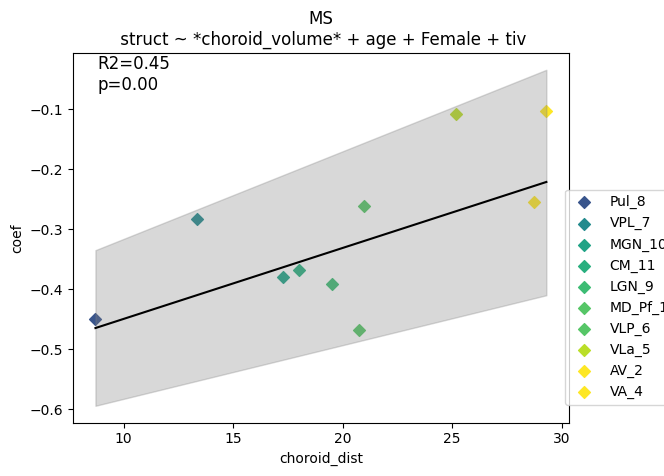

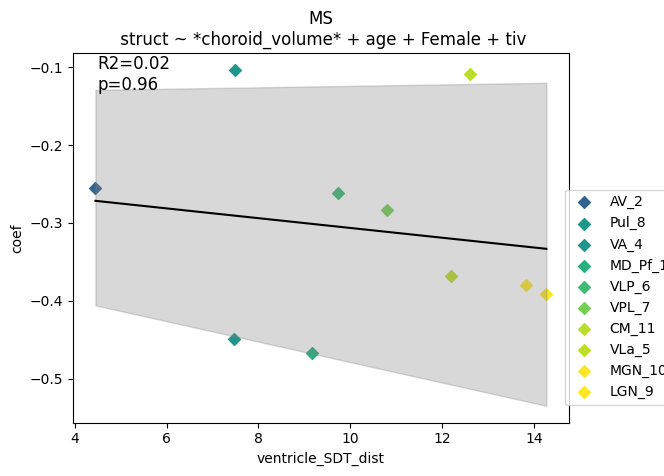

In [46]:
from statistics import mean

structs = hips_thomas_ref[thalamic_nuclei]
regression_results = regress_all_nuclei2(model_data, covariates, predictor, structs)
data = regression_results.copy()
data['choroid_dist'] = mni_dists['left_exposure']
data['ventricle_SDT_dist'] = mean_ventricle_dists_sdt

i=0
x_range = np.linspace(data['choroid_dist'].min(), data['choroid_dist'].max())
fig, axs = plt.subplots()
slopes = all_slopes[i]
intercepts = all_intercepts[i]

sort_slopes = sorted(slopes)
sort_intercepts = sorted(intercepts)
y_low = sort_intercepts[25] + sort_slopes[25]*x_range
y_high = sort_intercepts[975] + sort_slopes[975]*x_range
y = mean(sort_intercepts) + mean(sort_slopes)*x_range

r2 = all_r[i].mean()**2
p = all_p_boot[i]

plot_xordered_data(data, "choroid_dist", "coef", "struct", fit_line=False,
                title=f"MS\n struct ~ *{predictor}* + {covariates}",
                axes=axs, fig=fig, legend=True, loc=(0.85, 0.15), fit_params=False)

axs.fill_between(x_range, y_low, y_high, alpha=0.3, color="gray")
axs.plot(x_range, y, color='black')
xlims = axs.get_xlim()
ylims = axs.get_ylim()
text = "R2={:0.2f}\np={:0.2f}".format(r2, p)
text_y = ylims[0] + (ylims[1] - ylims[0]) * 0.9
text_x = xlims[0] + (xlims[1] - xlims[0]) * 0.05
axs.text(text_x, text_y, text, fontsize=12)
plt.savefig(fig_path / "choroid_correlations_thalamuc_nuclei_v_cp_dist_shading.png", dpi=300)

i=1
x_range = np.linspace(data['ventricle_SDT_dist'].min(), data['ventricle_SDT_dist'].max())
fig, axs = plt.subplots()
slopes = all_slopes[i]
intercepts = all_intercepts[i]

sort_slopes = sorted(slopes)
sort_intercepts = sorted(intercepts)
y_low = sort_intercepts[25] + sort_slopes[25]*x_range
y_high = sort_intercepts[975] + sort_slopes[975]*x_range
y = mean(sort_intercepts) + mean(sort_slopes)*x_range

r2 = all_r[i].mean()**2
p = all_p_boot[i]

plot_xordered_data(data, "ventricle_SDT_dist", "coef", "struct", fit_line=False,
                title=f"MS\n struct ~ *{predictor}* + {covariates}",
                axes=axs, fig=fig, legend=True, loc=(0.85, 0.15), fit_params=False)

axs.fill_between(x_range, y_low, y_high, alpha=0.3, color="gray")
axs.plot(x_range, y, color='black')
xlims = axs.get_xlim()
ylims = axs.get_ylim()
text = "R2={:0.2f}\np={:0.2f}".format(r2, p)
text_y = ylims[0] + (ylims[1] - ylims[0]) * 0.9
text_x = xlims[0] + (xlims[1] - xlims[0]) * 0.05
axs.text(text_x, text_y, text, fontsize=12)

plt.savefig(fig_path / "choroid_correlations_thalamuc_nuclei_v_ventricle_dist_shading.png", dpi=300)

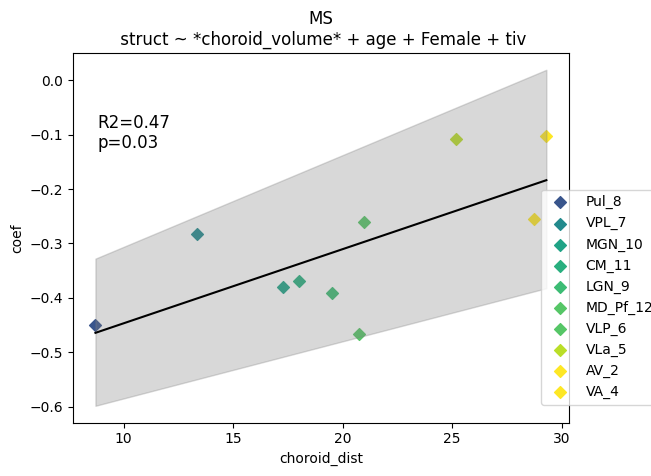

In [114]:
from statistics import mean
x_range = np.linspace(data['choroid_dist'].min(), data['choroid_dist'].max())

sort_slopes = sorted(all_slopes[0])
sort_intercepts = sorted(all_intercepts[0])
y_low = sort_intercepts[25] + sort_slopes[25]*x_range
y_high = sort_intercepts[975] + sort_slopes[975]*x_range
y = mean(sort_intercepts) + mean(sort_slopes)*x_range
fig, axs = plt.subplots()

plot_xordered_data(data, "choroid_dist", "coef", "struct", fit_line=False,
                title=f"MS\n struct ~ *{predictor}* + {covariates}",
                axes=axs, fig=fig, legend=True, loc=(0.83, 0.15))
axs.fill_between(x_range, y_low, y_high, alpha=0.3, color="gray")
axs.plot(x_range, y, color='black')


In [47]:
model_data = df_z.join([df_thomas_z, model_data_v_dists])
model_data = model_data[model_data['dz_type3'] == "MS"]
# structs = df_thomas.columns
structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33", "Acc_26", "Cla_28"])]
# structs = hips_thomas_ref[thalamic_nuclei]
# structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33", "Hb_13", "MTT_14"])]
covariates = "age + Female + tiv"

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# predictors = ["choroid_volume", "cortical_thickness", "t2lv", "PRL"]
predictors = ["choroid_volume", "cortical_thickness", "t2lv", "PRL"]
for i, outcome in enumerate(predictors):
    regression_results = regress_all_nuclei2(model_data, covariates, outcome, structs)

    data = regression_results.copy()
    data = regression_results[regression_results.pvals < 0.05]
    # data['dist'] = mni_dists['left_exposure']
    data['dist'] = mean_ventricle_dists_sdt

    if i == len(predictors) - 1:
        legend = True
    else:
        legend = False
    multi_index = np.unravel_index(i, axs.shape)
    if multi_index[0] == 1:
        hide_x=False
    else:
        hide_x=True
    plot_xordered_data(data, "dist", "coef", "struct", fit_line=True,
                    title=f"MS\n struct ~ *{outcome}* + {covariates}",
                    axes=axs[multi_index], fig=fig, legend=legend, loc=(0.91, 0.15), fdr=False,
                    hide_x=hide_x)
    
# regression_results.sort_values(by="coef")

NameError: name 'model_data_v_dists' is not defined

In [20]:
mean_ventricle_dists

14    14.093234
16    16.644883
15    15.868516
11    11.713387
16    16.389998
17    17.928940
27    27.695768
21    21.085337
13    13.375790
9      9.574084
14    14.313638
20    20.858191
40    40.272149
30    30.794110
40    40.122565
27    27.549220
25    25.704484
32    32.905154
22    22.497379
dtype: float64

In [63]:
structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33"])]

all_slopes = []
all_r = []
all_p_boot = []
all_intercepts = []
for i, pred in enumerate(predictors):
    if pred == "cortical_thickness":
        slopes, intercepts, r_vals, p_boot = bootstrap_procedure2(model_data, mni_dists['left_exposure'], covariates, pred, structs, inverse_slope=True)
    else:
        slopes, intercepts, r_vals, p_boot = bootstrap_procedure2(model_data, mni_dists['left_exposure'], covariates, pred, structs)
    all_slopes.append(slopes)
    all_r.append(r_vals)
    all_p_boot.append(p_boot)
    all_intercepts.append(intercepts)

clear_output(wait=True)

for i, pred in enumerate(predictors):
    print(pred)
    r_values = all_r[i]
    r_values.sort()
    mean_r_value = r_values.mean()
    print("R2: {:0.2} [{:0.2}, {:0.2}]".format(mean_r_value**2, r_values[25]**2, r_values[975]**2))
    p_boot = all_p_boot[i]
    print("Bootstrapped p: {:0.2f}".format(p_boot))
    print("---")

choroid_volume
R2: 0.25 [0.13, 0.38]
Bootstrapped p: 0.00
---
cortical_thickness
R2: 0.31 [0.4, 0.22]
Bootstrapped p: 0.00
---
t2lv
R2: 0.32 [0.18, 0.45]
Bootstrapped p: 0.00
---
PRL
R2: 0.4 [0.25, 0.59]
Bootstrapped p: 0.00
---


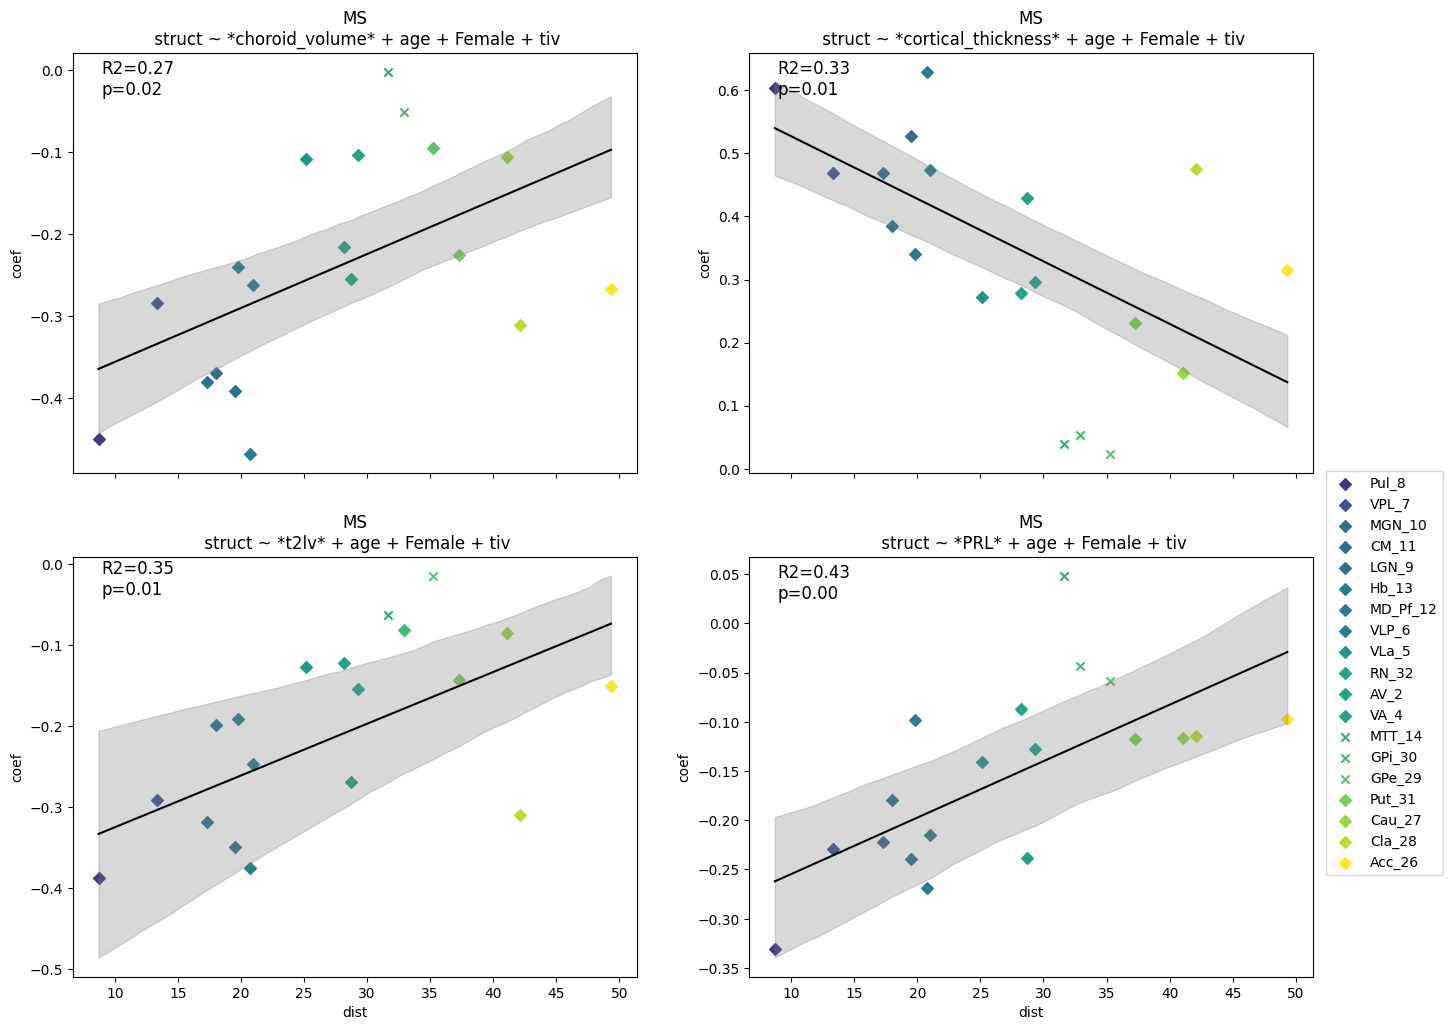

In [64]:
x_range = np.linspace(data['dist'].min(), data['dist'].max())
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

for i, outcome in enumerate(predictors):
    slopes = all_slopes[i]
    intercepts = all_intercepts[i]
    y_boot = np.zeros((1000, len(x_range)))
    for i_boot in range(1000):
        y_boot[i_boot, :] = intercepts[i_boot] + slopes[i_boot]*x_range
    y_boot = np.sort(y_boot, axis=0)
    y_low = y_boot[25, :]
    y_high = y_boot[975, :]
    r2 = all_r[i].mean()
    p = all_p_boot[i]

    regression_results = regress_all_nuclei2(model_data, covariates, outcome, structs)

    data = regression_results.copy()
    data['dist'] = mni_dists['left_exposure']

    if i == len(predictors) - 1:
        legend = True
    else:
        legend = False

    multi_index = np.unravel_index(i, axs.shape)
    if multi_index[0] == 1:
        hide_x=False
    else:
        hide_x=True

    plot_xordered_data(data, "dist", "coef", "struct", fit_line=False,
                    title=f"MS\n struct ~ *{outcome}* + {covariates}",
                    axes=axs[multi_index], fig=fig, legend=legend, loc=(0.91, 0.15), hide_x=hide_x)

    axs[multi_index].fill_between(x_range, y_low, y_high, alpha=0.3, color="gray")
    axs[multi_index].plot(x_range, y_boot.mean(axis=0), color='black')

plt.savefig(fig_path/"inflammatory_markers.png", dpi=300)

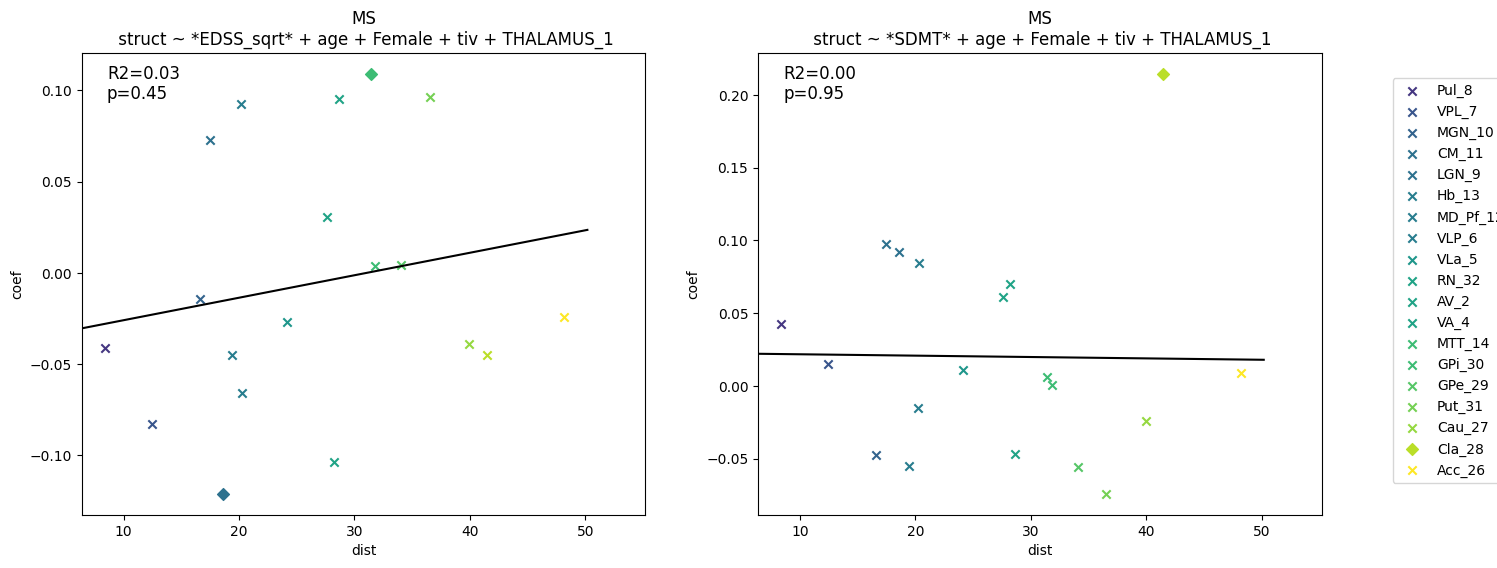

In [37]:
model_data = df_z.join([df_thomas_z])
model_data = model_data[model_data['dz_type3'] == "MS"]
covariates = "age + Female + tiv + THALAMUS_1"


fig, axs = plt.subplots(1, 2, figsize=(16, 6))
structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33"])]
# structs = hips_thomas_ref[thalamic_nuclei]

predictors = ["EDSS_sqrt", "SDMT"]
for i, outcome in enumerate(predictors):
    regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)

    # data = regression_results[regression_results['pvals'] < 0.05]
    data = regression_results
    data['dist'] = mni_dists['right_exposure']

    if i == len(predictors) - 1:
        legend = True
    else:
        legend = False
    plot_xordered_data(data, "dist", "coef", "struct", fit_line=True,
                    title=f"MS\n struct ~ *{outcome}* + {covariates}",
                    axes=axs[i], fig=fig, legend=legend, loc=(0.93, 0.15))

In [17]:
all_slopes = []
all_r = []
all_p_boot = []
all_intercepts = []
for i, pred in enumerate(predictors):
    slopes, intercepts, r_vals, p_boot = bootstrap_procedure2(model_data, mni_dists['left_exposure'], covariates, pred, structs)
    all_slopes.append(slopes)
    all_r.append(r_vals)
    all_p_boot.append(p_boot)
    all_intercepts.append(intercepts)

clear_output(wait=True)

for i, pred in enumerate(predictors):
    print(pred)
    r_values = all_r[i]
    r_values.sort()
    mean_r_value = r_values.mean()
    print("R2: {:0.2} [{:0.2}, {:0.2}]".format(mean_r_value**2, r_values[25]**2, r_values[975]**2))
    p_boot = all_p_boot[i]
    print("Bootstrapped p: {:0.2f}".format(p_boot))
    print("---")

EDSS_sqrt
R2: 0.31 [0.16, 0.51]
Bootstrapped p: 0.00
---
SDMT
R2: 0.22 [0.4, 0.074]
Bootstrapped p: 1.00
---


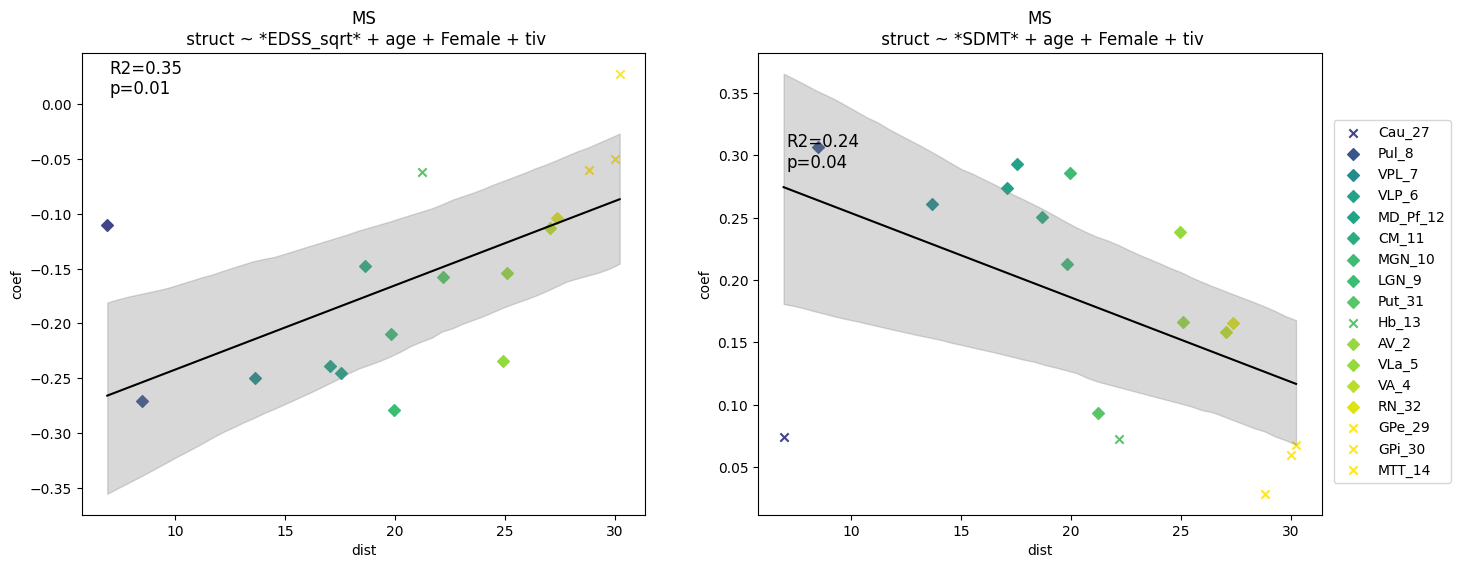

In [18]:
x_range = np.linspace(data['dist'].min(), data['dist'].max())
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

for i, outcome in enumerate(predictors):
    slopes = all_slopes[i]
    intercepts = all_intercepts[i]
    y_boot = np.zeros((1000, len(x_range)))
    for i_boot in range(1000):
        y_boot[i_boot, :] = intercepts[i_boot] + slopes[i_boot]*x_range
    y_boot = np.sort(y_boot, axis=0)
    y_low = y_boot[25, :]
    y_high = y_boot[975, :]

    regression_results = regress_all_nuclei2(model_data, covariates, outcome, structs)

    data = regression_results.copy()
    data['dist'] = mni_dists['left_exposure']

    if i == len(predictors) - 1:
        legend = True
    else:
        legend = False
    plot_xordered_data(data, "dist", "coef", "struct", fit_line=False,
                    title=f"MS\n struct ~ *{outcome}* + {covariates}",
                    axes=axs[i], fig=fig, legend=legend, loc=(0.91, 0.15))
    
    
    axs[i].fill_between(x_range, y_low, y_high, alpha=0.3, color="gray")
    axs[i].plot(x_range, y_boot.mean(axis=0), color='black')

plt.savefig(fig_path/"disability_exclude_far_structs2.png", dpi=300)

#### Just Thalamic Nuclei

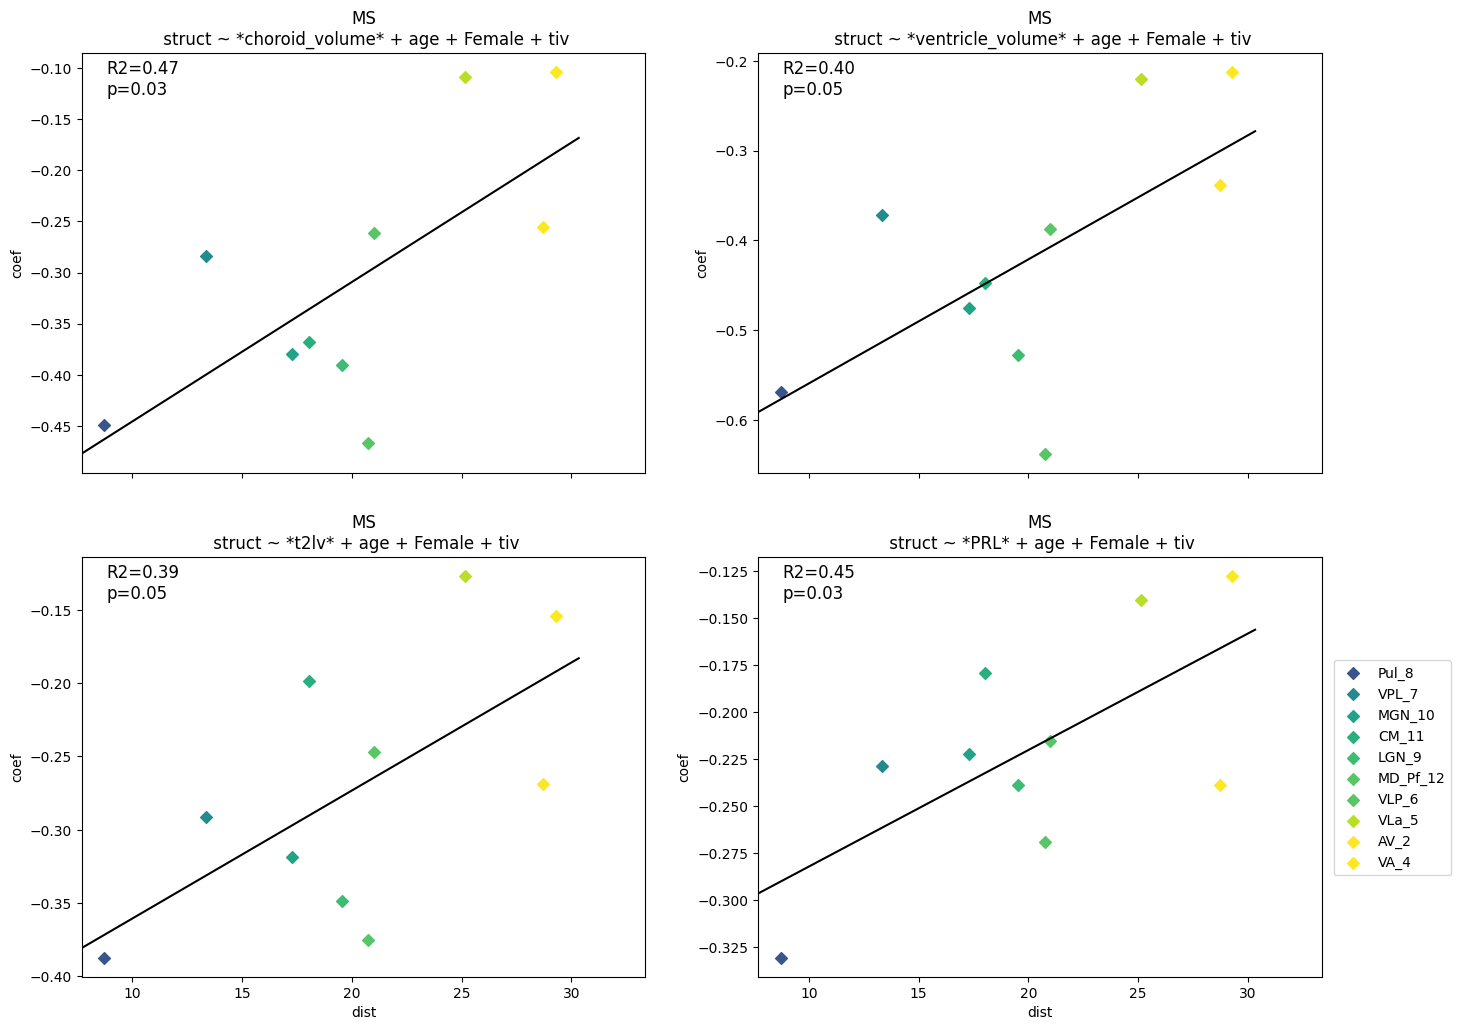

In [9]:
model_data = df_z.join([df_thomas_z])
model_data = model_data[model_data['dz_type2'] == "MS"]
# structs = df_thomas.columns
structs = hips_thomas_ref[thalamic_nuclei]
covariates = "age + Female + tiv"

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

predictors = ["choroid_volume", "ventricle_volume", "t2lv",  "PRL"]
for i, outcome in enumerate(predictors):
    regression_results = regress_all_nuclei2(model_data, covariates, outcome, structs)

    data = regression_results.copy()
    data['dist'] = mni_dists['left_exposure']
    # data['dist'] = mean_cho
    # data['dist'] = mean_ventricle_dists_sdt

    if i == len(predictors) - 1:
        legend = True
    else:
        legend = False
    multi_index = np.unravel_index(i, axs.shape)
    if multi_index[0] == 1:
        hide_x=False
    else:
        hide_x=True
    plot_xordered_data(data, "dist", "coef", "struct", fit_line=True,
                    title=f"MS\n struct ~ *{outcome}* + {covariates}",
                    axes=axs[multi_index], fig=fig, legend=legend, loc=(0.91, 0.15),
                    hide_x=hide_x)

In [10]:
regression_results = regress_all_nuclei2(model_data, covariates, "t2lv", structs)
regression_results.sort_values(by="coef")

,struct,coef,pvals,se,p_fdr,coef_sig
8,Pul_8,-0.387270,4.293796e-22,0.087861,4.293796e-21,-0.387270
12,MD_Pf_12,-0.375241,2.157618e-20,0.085203,1.078809e-19,-0.375241
9,LGN_9,-0.348775,2.449769e-16,0.088265,6.124421e-16,-0.348775
10,MGN_10,-0.318682,6.025835e-17,0.065607,2.008612e-16,-0.318682
7,VPL_7,-0.291163,1.959357e-13,0.064638,3.918715e-13,-0.291163
2,AV_2,-0.269011,5.976030e-12,0.064732,9.960051e-12,-0.269011
6,VLP_6,-0.247008,8.033008e-11,0.059489,1.147573e-10,-0.247008
11,CM_11,-0.198222,3.425856e-07,0.069765,4.282320e-07,-0.198222
4,VA_4,-0.154355,1.704937e-05,0.039768,1.894374e-05,-0.154355
5,VLa_5,-0.126764,4.758460e-04,0.041481,4.758460e-04,-0.126764


In [69]:
all_slopes = []
all_r = []
all_p_boot = []
all_intercepts = []
for i, pred in enumerate(predictors):
    slopes, intercepts, r_vals, p_boot = bootstrap_procedure2(model_data, mni_dists['left_exposure'], covariates, pred, structs)
    all_slopes.append(slopes)
    all_r.append(r_vals)
    all_p_boot.append(p_boot)
    all_intercepts.append(intercepts)

clear_output(wait=True)

for i, pred in enumerate(predictors):
    print(pred)
    r_values = all_r[i]
    r_values.sort()
    mean_r_value = r_values.mean()
    print("R2: {:0.2} [{:0.2}, {:0.2}]".format(mean_r_value**2, r_values[25]**2, r_values[975]**2))
    p_boot = all_p_boot[i]
    print("Bootstrapped p: {:0.2f}".format(p_boot))
    print("---")

choroid_volume
R2: 0.45 [0.32, 0.58]
Bootstrapped p: 0.00
---
cortical_thickness
R2: 0.35 [0.51, 0.21]
Bootstrapped p: 1.00
---
t2lv
R2: 0.36 [0.2, 0.52]
Bootstrapped p: 0.00
---
PRL
R2: 0.39 [0.13, 0.64]
Bootstrapped p: 0.00
---


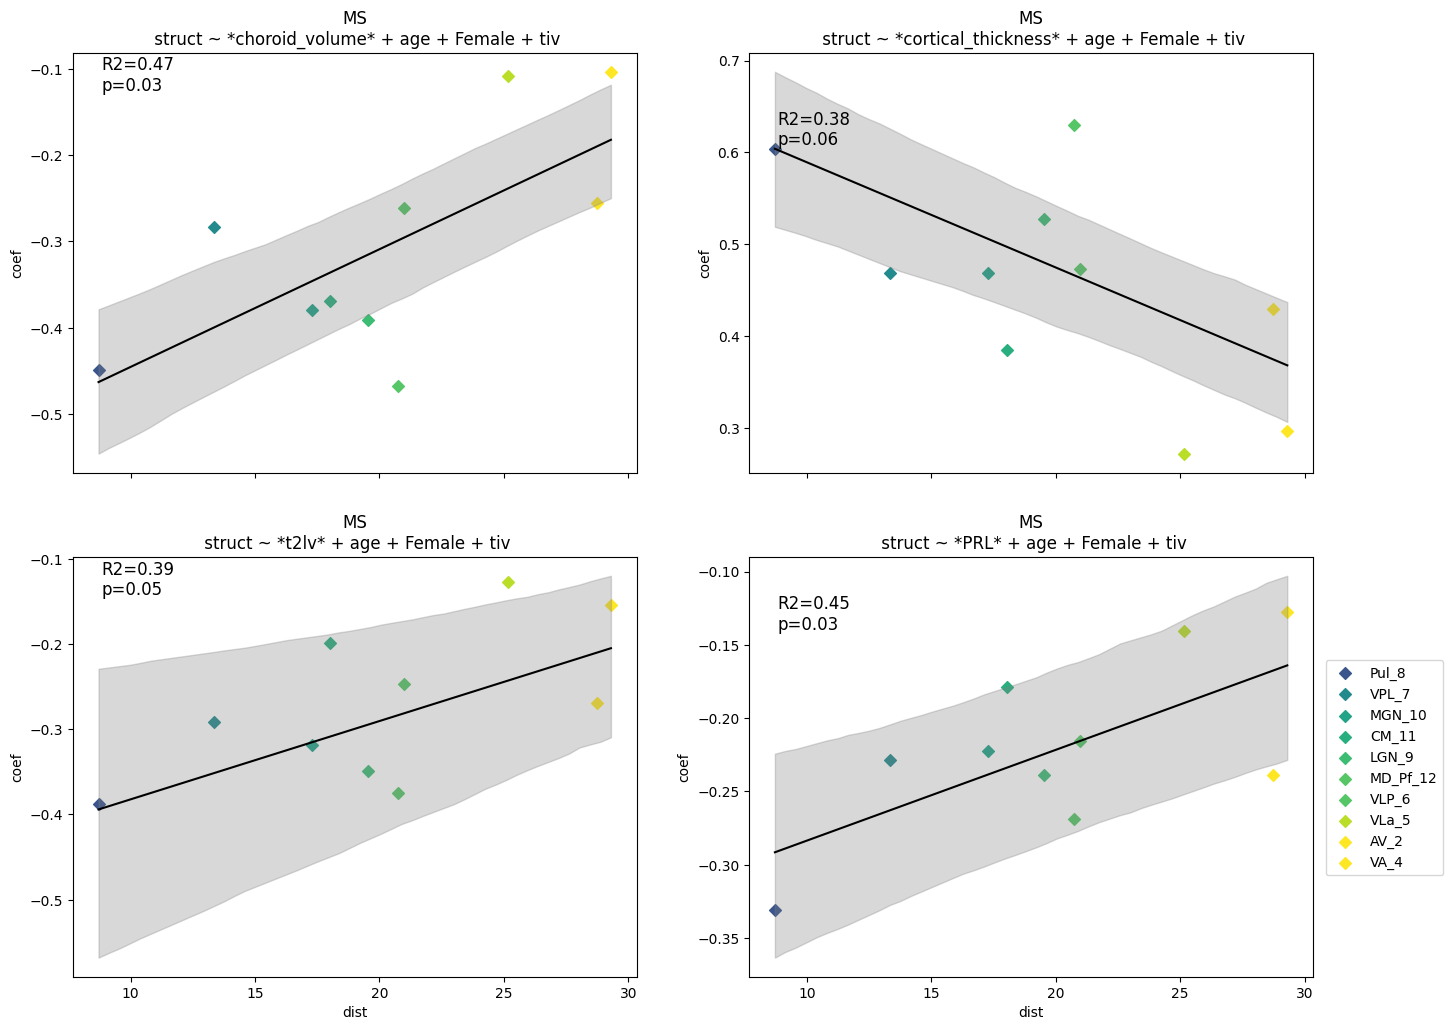

In [70]:
x_range = np.linspace(data['dist'].min(), data['dist'].max())
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

for i, outcome in enumerate(predictors):
    slopes = all_slopes[i]
    intercepts = all_intercepts[i]
    y_boot = np.zeros((1000, len(x_range)))
    for i_boot in range(1000):
        y_boot[i_boot, :] = intercepts[i_boot] + slopes[i_boot]*x_range
    y_boot = np.sort(y_boot, axis=0)
    y_low = y_boot[25, :]
    y_high = y_boot[975, :]
    r2 = all_r[i].mean()
    p = all_p_boot[i]

    regression_results = regress_all_nuclei2(model_data, covariates, outcome, structs)

    data = regression_results.copy()
    data['dist'] = mni_dists['left_exposure']

    if i == len(predictors) - 1:
        legend = True
    else:
        legend = False

    multi_index = np.unravel_index(i, axs.shape)
    if multi_index[0] == 1:
        hide_x=False
    else:
        hide_x=True

    plot_xordered_data(data, "dist", "coef", "struct", fit_line=False,
                    title=f"MS\n struct ~ *{outcome}* + {covariates}",
                    axes=axs[multi_index], fig=fig, legend=legend, loc=(0.91, 0.15), hide_x=hide_x)

    axs[multi_index].fill_between(x_range, y_low, y_high, alpha=0.3, color="gray")
    axs[multi_index].plot(x_range, y_boot.mean(axis=0), color='black')

plt.savefig(fig_path/"inflammatory_markers_thalamic_nuclei.png", dpi=300)

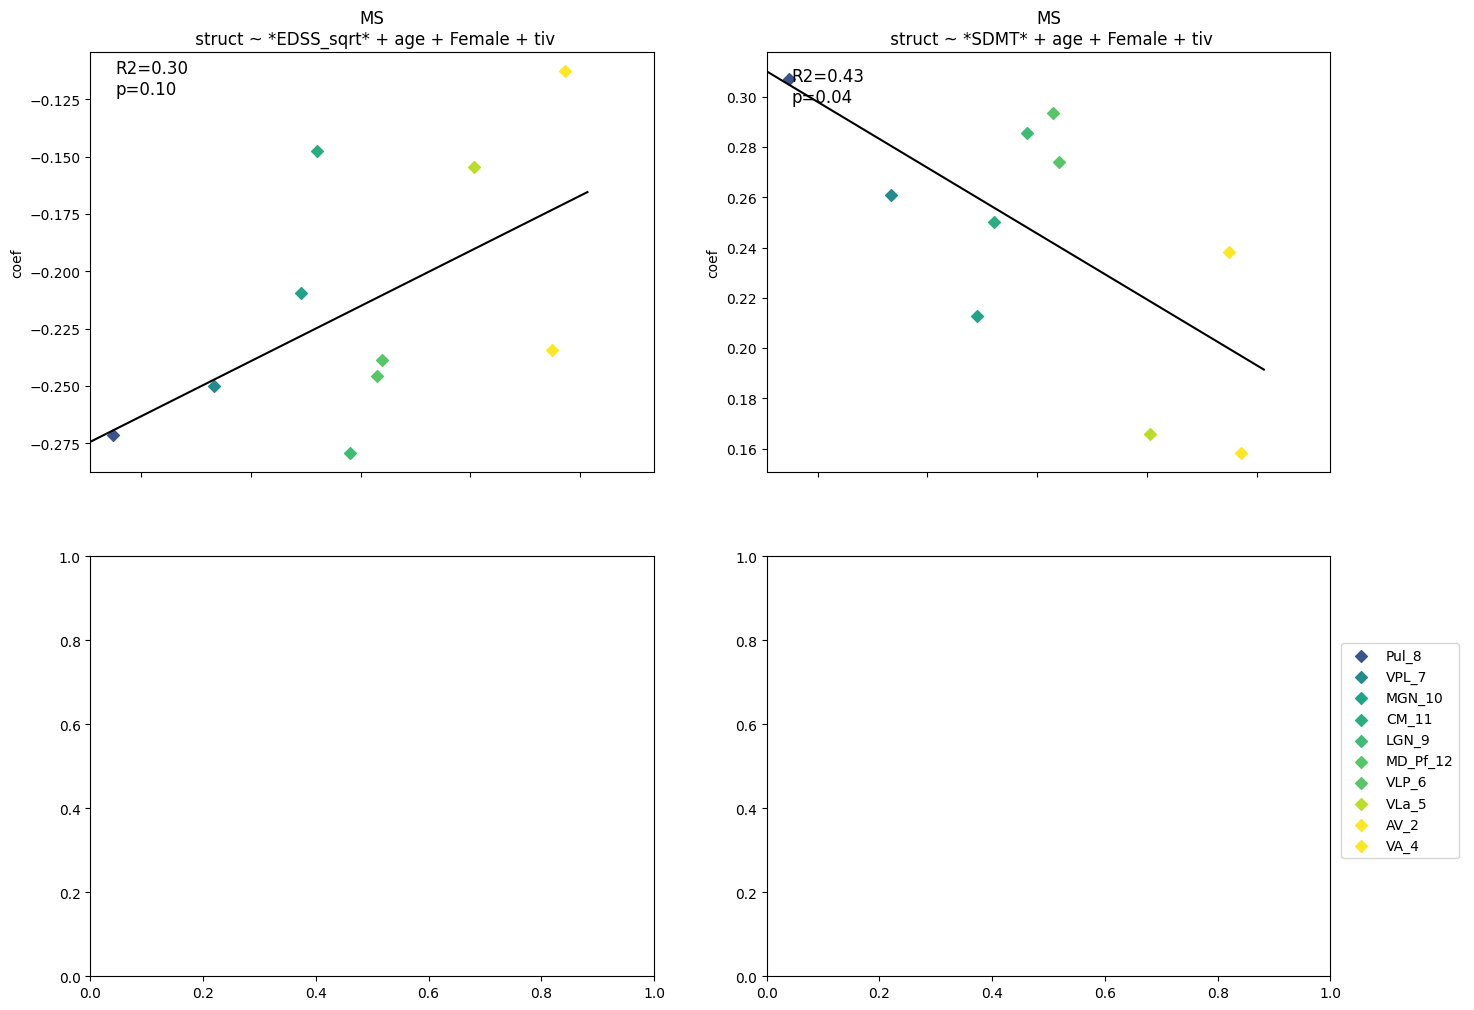

In [7]:
model_data = df_z.join([df_thomas_z])
model_data = model_data[model_data['dz_type2'] == "MS"]
# structs = df_thomas.columns
structs = hips_thomas_ref[thalamic_nuclei]
covariates = "age + Female + tiv"

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

predictors = ["EDSS_sqrt", "SDMT"]
for i, outcome in enumerate(predictors):
    regression_results = regress_all_nuclei2(model_data, covariates, outcome, structs)

    data = regression_results.copy()
    data['dist'] = mni_dists['left_exposure']

    if i == len(predictors) - 1:
        legend = True
    else:
        legend = False
    multi_index = np.unravel_index(i, axs.shape)
    if multi_index[0] == 1:
        hide_x=False
    else:
        hide_x=True
    plot_xordered_data(data, "dist", "coef", "struct", fit_line=True,
                    title=f"MS\n struct ~ *{outcome}* + {covariates}",
                    axes=axs[multi_index], fig=fig, legend=legend, loc=(0.91, 0.15),
                    hide_x=hide_x)

#### All Structures

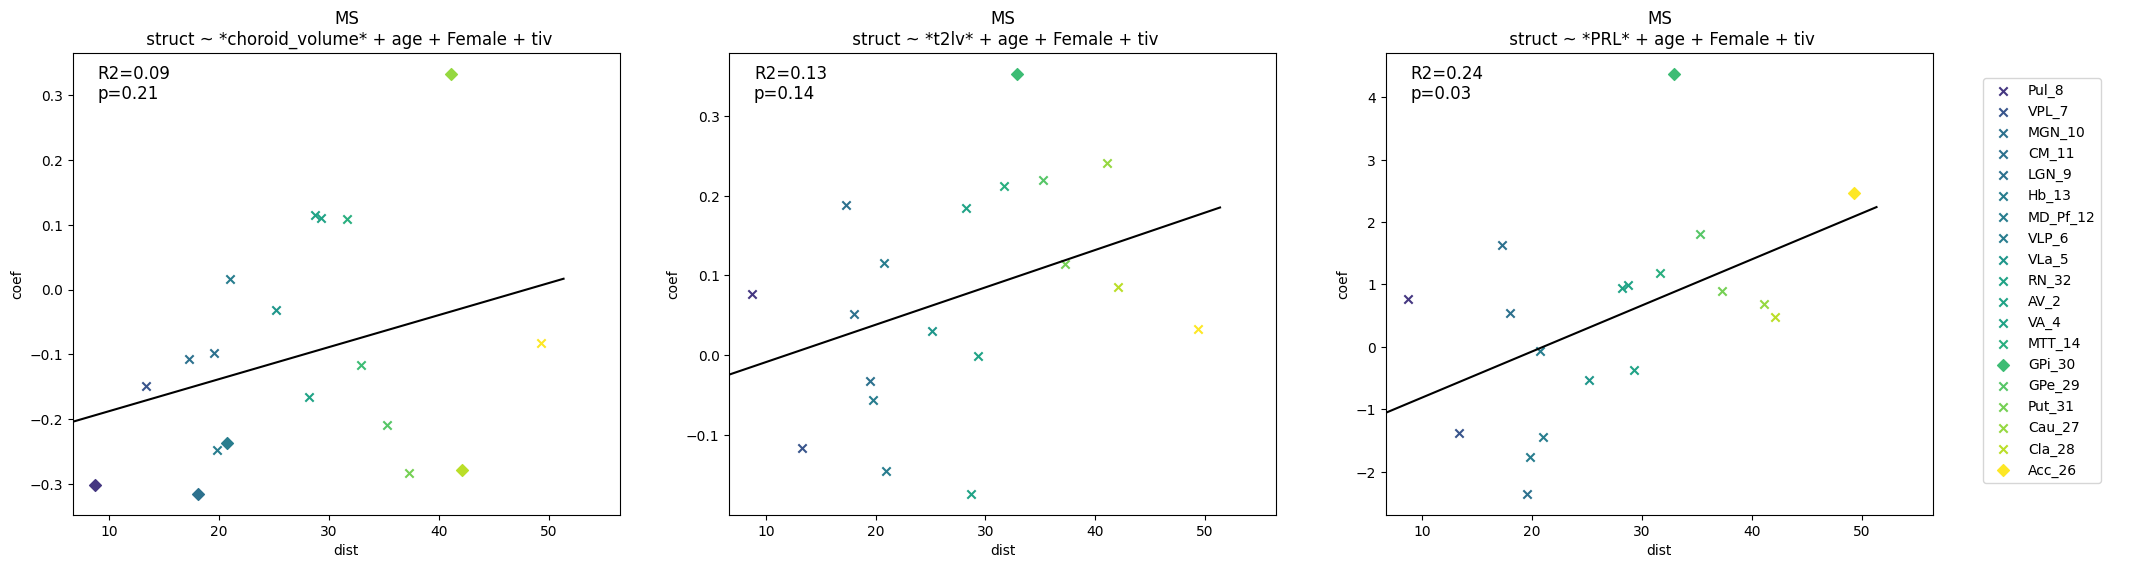

In [36]:
model_data = df_z.join([df_thomas_z])
model_data = model_data[model_data['dz_type5'] == "NIND"]
structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33"])]
covariates = "age + Female + tiv"

fig, axs = plt.subplots(1, 3, figsize=(24, 6))

# predictors = ["choroid_volume", "t2lv", "PRL"]
predictors = ["choroid_volume", "t2lv", "PRL"]
for i, outcome in enumerate(predictors):
    regression_results = regress_all_nuclei2(model_data, covariates, outcome, structs)

    data = regression_results.copy()
    data['dist'] = mni_dists['left_exposure']

    if i == len(predictors) - 1:
        legend = True
    else:
        legend = False
    plot_xordered_data(data, "dist", "coef", "struct", fit_line=True,
                    title=f"MS\n struct ~ *{outcome}* + {covariates}",
                    axes=axs[i], fig=fig, legend=legend, loc=(0.93, 0.15))
    
# plt.savefig(fig_path / "inflammatory_markers_all_structs.png", dpi=300)

#### Compositional

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not

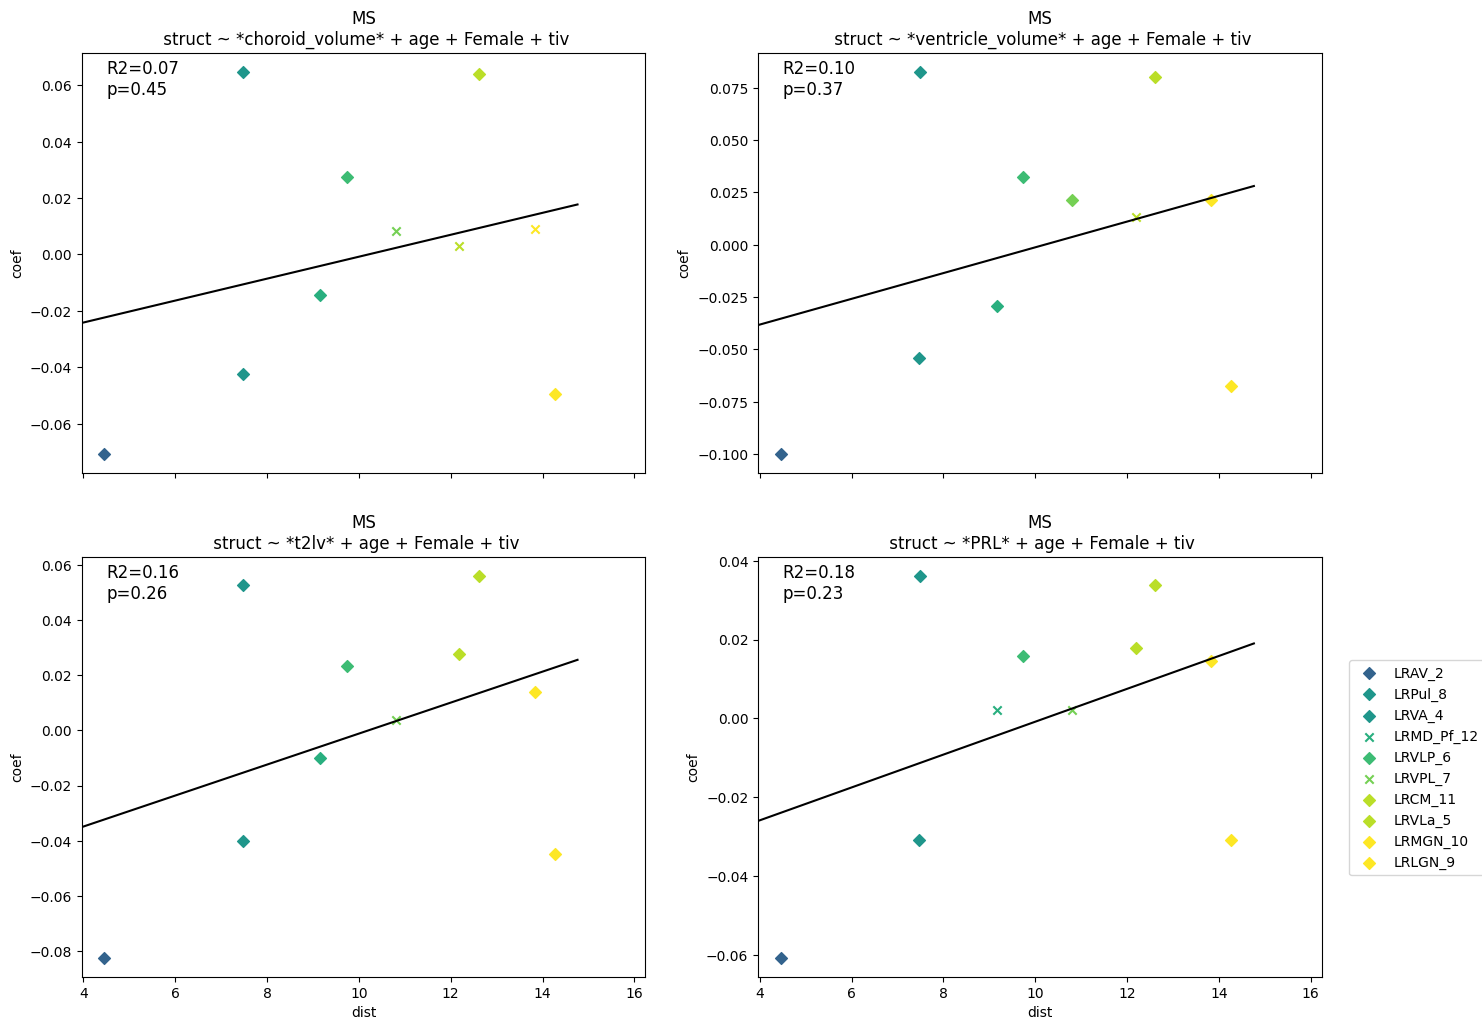

In [51]:
model_data = df_z.join([df_thomas])
model_data = model_data[model_data['dz_type2'] == "MS"]

for struct in hips_thomas_ref[thalamic_nuclei]:
    denom = list(set(hips_thomas_ref[thalamic_nuclei]) - set(struct))
    model_data[f'LR{struct}'] = log_ratio(model_data[struct].T, model_data[denom].T).T
    
covariates = "age + Female + tiv"

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

structsLR = [f"LR{struct}" for struct in hips_thomas_ref[thalamic_nuclei]] 

predictors = ["choroid_volume", "ventricle_volume", "t2lv",  "PRL"]
for i, outcome in enumerate(predictors):
    regression_results = regress_all_nuclei2(model_data, covariates, outcome, structsLR)

    data = regression_results.copy()
    data['dist'] = mni_dists['left_exposure']
    # data['dist'] = mean_cho
    data['dist'] = mean_ventricle_dists_sdt

    if i == len(predictors) - 1:
        legend = True
    else:
        legend = False
    multi_index = np.unravel_index(i, axs.shape)
    if multi_index[0] == 1:
        hide_x=False
    else:
        hide_x=True
    plot_xordered_data(data, "dist", "coef", "struct", fit_line=True,
                    title=f"MS\n struct ~ *{outcome}* + {covariates}",
                    axes=axs[multi_index], fig=fig, legend=legend, loc=(0.91, 0.15),
                    hide_x=hide_x)

In [38]:
model_data = df_z.join([df_thomas])

num = ['Pul_8']
denom = list(set(hips_thomas_ref[thalamic_nuclei]) - set(num))
check = log_ratio(model_data[num].T, model_data[denom].T).T

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [28]:
geo_mean(model_data[denom].T)

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


np.float64(inf)

In [14]:
set(hips_thomas_ref[thalamic_nuclei])

{'AV_2',
 'CM_11',
 'LGN_9',
 'MD_Pf_12',
 'MGN_10',
 'Pul_8',
 'VA_4',
 'VLP_6',
 'VLa_5',
 'VPL_7'}

---

## Prepare data for R

In [30]:
choroid_dists = pd.read_csv(data_dir / "centroid-choroid_SDT.csv", index_col="subid")
choroid_dists = choroid_dists.apply(stats.zscore, nan_policy="omit")
ventricle_dists = pd.read_csv(data_dir / "centroid-ventricle_SDT.csv", index_col="subid")
# model_data = df.join([df_thomas, choroid_dists])
model_data = df_z.join([df_thomas_z, choroid_dists])
# subids_remove = [2108, 2070, 2005, 1423, 1383, 1355, 1344, 1280, 1283, 1285, 2110]
# subids_remove = subids_remove + [1027, 1029, 1064, 1101, 1105, 1203, 1224, 1317, 1406, 1437, 1463, 1476, 1486]
subids_remove = [1011]
model_data = model_data.loc[~model_data.index.isin(subids_remove), :]
model_data = model_data.reset_index()
model_data = model_data[model_data['dz_type5'].isin(["RMS"])]
# model_data = model_data.loc[0:40, :]
choroid_dists = choroid_dists.loc[choroid_dists.index.isin(model_data.subid), :]

ventricle_dists = ventricle_dists.loc[ventricle_dists.index.isin(model_data.subid), :]

id_vars = ["dz_type3", "subid", "age", "Female", "tiv",  "choroid_volume", "dzdur", "THALAMUS_1", "cortical_thickness", "EDSS_sqrt", "SDMT"]
value_vars = hips_thomas_ref[~hips_thomas_ref.isin(['THALAMUS_1'])].values
save_data = model_data.melt(id_vars=id_vars, value_vars=value_vars)
save_data = save_data.set_index(['subid', 'variable'])
for i, row in choroid_dists.iterrows():
    for ind in row.index:
        struct = hips_thomas_ref[int(ind)]
        save_data.loc[(i, struct), "choroid_dist"] = row[ind]
for i, row in ventricle_dists.iterrows():
    for ind in row.index:
        struct = hips_thomas_ref[int(ind)]
        save_data.loc[(i, struct), "ventricle_dist"] = row[ind]

save_data = save_data.reset_index()
save_data = save_data[save_data['variable'].isin(hips_thomas_ref[thalamic_nuclei])]
# save_data = save_data[~save_data['variable'].isin(["Pul_8", "LGN_9"])]
save_data.to_csv("melted_data_for_R_RMS_thalamus_z.csv", index=False)

In [129]:
choroid_dists = pd.read_csv(data_dir / "centroid-choroid_SDT.csv", index_col="subid")

model_data = df.join([df_thomas, choroid_dists])
# subids_remove = [2108, 2070, 2005, 1423, 1383, 1355, 1344, 1280, 1283, 1285, 2110]
# subids_remove = subids_remove + [1027, 1029, 1064, 1101, 1105, 1203, 1224, 1317, 1406, 1437, 1463, 1476, 1486]
subids_remove = [1011]
model_data = model_data.loc[~model_data.index.isin(subids_remove), :]
model_data = model_data.reset_index()
model_data = model_data[model_data['dz_type5']  == "OIND"]
# model_data = model_data.loc[0:40, :]
choroid_dists = choroid_dists.loc[choroid_dists.index.isin(model_data.subid), :]

value_vars = hips_thomas_ref[~hips_thomas_ref.isin(['THALAMUS_1'])].values
model_data[value_vars] = model_data[value_vars].apply(stats.zscore, nan_policy="omit")
choroid_dists = choroid_dists.apply(stats.zscore, nan_policy="omit")
save_data = model_data.melt(id_vars=id_vars, value_vars=value_vars)
save_data = save_data.set_index(['subid', 'variable'])
for i, row in choroid_dists.iterrows():
    for ind in row.index:
        struct = hips_thomas_ref[int(ind)]
        save_data.loc[(i, struct), "choroid_dist"] = row[ind]

In [78]:
rng = np.random.default_rng()
unique_integers = rng.choice(len(choroid_dists.columns), size=len(choroid_dists.columns), replace=False)
new_cols = choroid_dists.columns[unique_integers]
rename_dict = {choroid_dists.columns[i]: new_cols[i] for i in range(len(new_cols))}
choroid_dists_shuffle = choroid_dists.rename(columns=rename_dict)
# np.random.sample(len(choroid_dists.columns))
# choroid_dists.columns

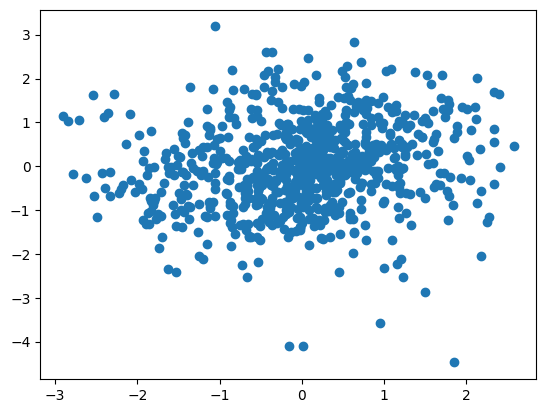

In [130]:
plt.scatter(save_data['choroid_dist'], save_data['value'])

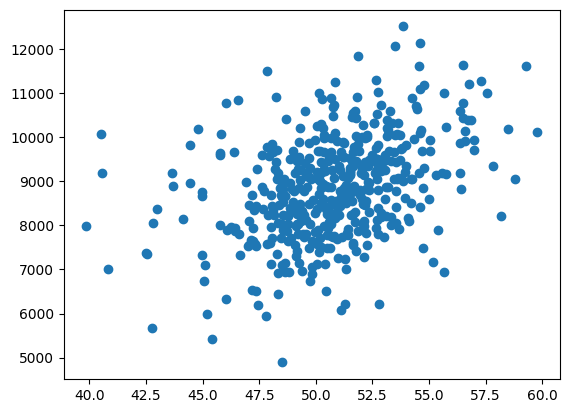

In [118]:
ind = 31
plt.scatter(model_data[str(ind)], model_data[hips_thomas_ref[ind]])

In [85]:
choroid_dists

,2,4,5,6,7,8,9,10,11,12,13,14,26,27,28,29,30,31,32
subid,,,,,,,,,,,,,,,,,,,
1003,28.642888,32.985501,31.515177,27.076038,26.958057,21.237230,35.958432,24.170866,22.905594,20.488633,15.828126,32.588755,58.234231,48.716133,58.758228,46.036054,43.339400,51.628488,27.787500
1005,26.439120,30.260803,28.621503,25.008528,23.139489,19.174941,32.478587,21.752288,19.582244,19.285476,14.381252,31.477236,54.311446,47.331709,55.504949,43.460843,40.227921,48.516009,25.796667
1007,30.595364,34.377582,33.721789,30.690725,29.102261,24.238330,37.246065,24.832470,23.443201,22.084982,14.633860,31.760011,57.624870,50.275053,59.847179,47.340489,44.168492,52.759081,25.772935
1031,31.670542,34.552547,31.471844,27.178735,22.815867,17.150312,31.507421,21.609683,19.872877,20.664369,14.634253,32.859308,59.296980,54.092807,58.439224,46.263589,42.769884,52.043236,26.705296
1042,32.367378,34.807329,33.379106,30.231962,28.931626,24.265685,38.232586,24.313936,21.844894,21.771497,15.204348,30.689312,58.680969,54.785447,63.382295,48.860796,44.675654,55.317478,25.281027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2180,29.819334,29.680640,26.942637,25.018790,23.049978,17.901572,29.576613,18.181436,18.526197,18.661697,13.573723,28.241487,51.445032,48.291156,55.090059,42.428221,37.563219,47.356334,22.714620
2188,31.209024,34.714511,31.828656,27.404645,24.831103,18.115322,32.488141,22.401729,21.837903,21.119002,16.065311,34.612281,58.561917,50.719183,59.291685,47.018990,43.129812,51.933818,28.838990
2190,27.353502,31.834121,30.390214,26.262152,25.212341,21.485218,36.911043,23.091572,20.998759,19.367523,13.341328,30.642838,54.802581,48.403735,57.408475,44.635353,41.475595,50.596718,26.384037


In [49]:
check = pd.read_csv("melted_data_for_R.csv")
check2 = check.loc[~check.subid.isin([1011]), :]
check2 = check2[check2.columns[~check2.columns.isin(['Unnamed: 0'])]]
check2.index.name = "index"
check2.to_csv("melted_data_for_R2.csv")

---

## Old shit

#### Curve fit the regression coefficients

[0.04294186304269143, 0.06213514144959875, 0.032759827688607523]
0.5762311881866298 -92.20846222720333 -89.89069606048399


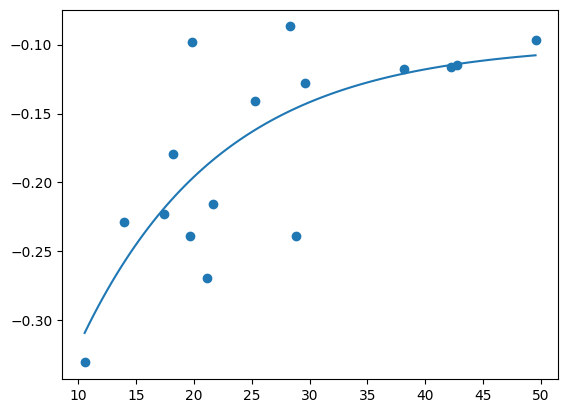

In [15]:
model_data = df_z.join([df_thomas_z])
model_data = model_data[model_data['dz_type2'] == "MS"]

covariates = "age + Female + tiv"
# covariates = ""

structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33", "GPe_29", "GPi_30", "MTT_14"])]
structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33", "GPe_29", "GPi_30", "MTT_14"])]

regression_results = regress_all_nuclei2(model_data, covariates, "PRL", structs)
regression_results['dist'] = mni_dists['left_exposure']

x_data = regression_results['dist']
y_data = regression_results['coef']

popt, pcov = curve_fit(saturation_curve, x_data, y_data, p0=[1, 0, 0])
x_model = np.linspace(x_data.min(), x_data.max(), 100)
y_model = saturation_curve(x_model, *popt)

plt.scatter(x_data, y_data)
plt.plot(x_model, y_model)

n = len(y_data)
p = len(popt)
stderr = np.sqrt(np.diag(pcov))
t_stats = popt / stderr
p_vals = [(1 - stats.t.cdf(np.abs(t_val), df=n - p)) for t_val in t_stats]
print(p_vals)

y_pred = saturation_curve(x_data, *popt)
r2 = r2_score(y_data, y_pred)
residuals = y_data - y_pred
rss = np.sum(residuals**2)
n = len(y_data)
k = len(popt)
aic = n * np.log(rss / n) + 2 * k
bic = n * np.log(rss / n) + k*np.log(n)

print(r2, aic, bic)

0.49276711649007277 -91.33194729806915 -89.78676985358959


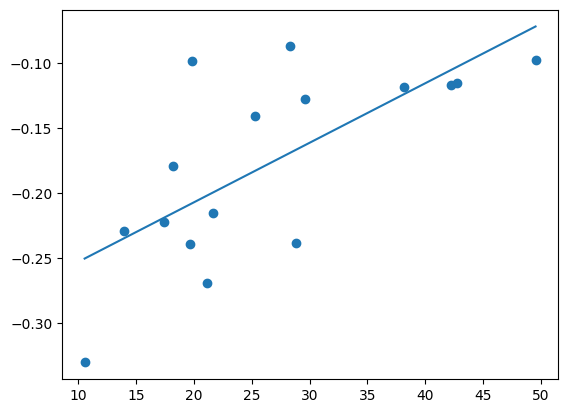

In [16]:
result = stats.linregress(x_data, y_data)
y_lin = result.intercept + result.slope*x_model
y_lin2 = result.intercept + result.slope*x_data
plt.scatter(x_data, y_data)
plt.plot(x_model, y_lin)
r2_lin = r2_score(y_data, y_lin2)

residuals = y_data - y_lin2
rss = np.sum(residuals**2)
k = 2
aic = n * np.log(rss / n) + 2 * k
bic = n * np.log(rss / n) + k*np.log(n)
print(r2_lin, aic, bic)

#### Curve fit the predictions

In [31]:
model_data = df.join([df_thomas])
model_data = model_data[model_data['dz_type2'] == "MS"]
# structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33", "Cla_28", "Acc_26", "Hb_13", "MTT_14"])]
structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33", "MTT_14", "GPe_29", "GPi_30"])]
# structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33", "MTT_14"])]

predictor = "PRL"
covariates = f"age + Female + tiv + {predictor}"
# outcome = "t2lv_logtrans"

vols = {}
dists = {}
for struct in structs:
    vols[struct] = []
    formula = f"{struct} ~ {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()

    model_data_mean = model_data[numeric_cols].mean()

    model_data_mean[predictor] = model_data[predictor].mean() - model_data[predictor].std()
    vols[struct].append(res.predict(model_data_mean)[0])

    model_data_mean[predictor] = model_data[predictor].mean() + model_data[predictor].std()
    res.predict(model_data_mean)[0]
    vols[struct].append(res.predict(model_data_mean)[0])

    ind = re.match(r".+_(\d+)$", struct)[1]

    dists[struct] = mni_dists.loc[int(ind), "left_exposure"]

[0.2350657206560257, 0.21401520041770883, 0.23617528344434335]

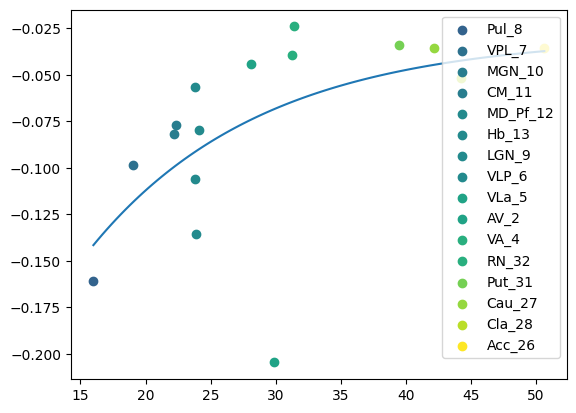

In [32]:
y_data = np.array([(item[1]-item[0])/item[0] for item in vols.values()])
x_data = np.array([item for item in dists.values()])

popt, pcov = curve_fit(saturation_curve, x_data, y_data, p0=[1, 0, 0])
x_pred = np.linspace(x_data.min(), x_data.max(), 100)
y_pred = saturation_curve(x_pred, *popt)

# plt.scatter(x_data, y_data)
sorted_inds = np.argsort(x_data)
labels = [item for item in dists.keys()]

for i in sorted_inds:
    x = x_data[i]
    y = y_data[i]
    lab = labels[i]
    c = x / x_data.max()
    plt.scatter(x, y, label=lab, color=viridis(c))

plt.plot(x_pred, y_pred)
plt.legend()

n = len(y_data)
p = len(popt)
stderr = np.sqrt(np.diag(pcov))
t_stats = popt / stderr
p_vals = [(1 - stats.t.cdf(np.abs(t_val), df=n - p)) for t_val in t_stats]
p_vals

In [22]:
y_pred = saturation_curve(x_data, *popt)
r2 = r2_score(y_data, y_pred)
residuals = y_data - y_pred
rss = np.sum(residuals**2)
n = len(y_data)
k = len(popt)
aic = n * np.log(rss / n) + 2 * k
bic = n * np.log(rss / n) + k*np.log(n)

print(r2, aic, bic)

0.46600038110898845 -100.02104629545093 -97.70328012873159


0.3037134863054045 -97.77518856807247 -96.2300111235929


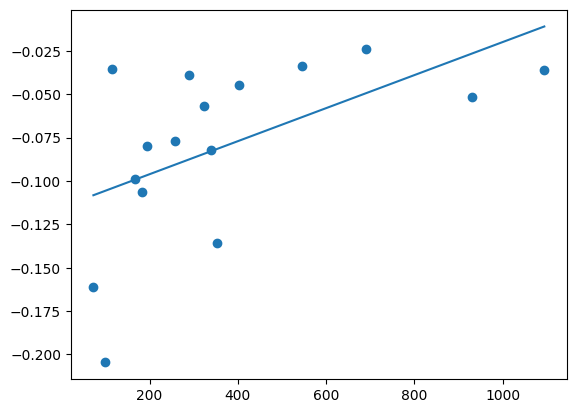

In [23]:
result = stats.linregress(x_data, y_data)
y_lin = result.intercept + result.slope*x_pred
y_lin2 = result.intercept + result.slope*x_data
plt.scatter(x_data, y_data)
plt.plot(x_pred, y_lin)
r2_lin = r2_score(y_data, y_lin2)

residuals = y_data - y_lin2
rss = np.sum(residuals**2)
k = 2
aic = n * np.log(rss / n) + 2 * k
bic = n * np.log(rss / n) + k*np.log(n)
print(r2_lin, aic, bic)

In [73]:
data_to_sample = df.join([df_thomas_left])
data_to_sample = data_to_sample[data_to_sample['dz_type2'] == "MS"]
data_to_sample = data_to_sample.reset_index()

structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33", "MTT_14", "GPe_29", "GPi_30"])]

predictor = "PRL"
covariates = f"age + Female + tiv + {predictor}"
all_popt = []
all_pcov = []

for i in tqdm(range(1000)):
    inds = np.random.randint(0, len(data_to_sample), len(data_to_sample))
    model_data = data_to_sample.loc[inds, :]

    vols = {}
    dists = {}
    for struct in structs:
        vols[struct] = []
        formula = f"{struct} ~ {covariates}"
        res = sm.OLS.from_formula(formula, data=model_data).fit()

        model_data_mean = model_data[numeric_cols].mean()
        model_data_mean[predictor] = model_data[predictor].mean() - model_data[predictor].std()
        vols[struct].append(res.predict(model_data_mean)[0])

        model_data_mean[predictor] = model_data[predictor].mean() + model_data[predictor].std()
        res.predict(model_data_mean)[0]
        vols[struct].append(res.predict(model_data_mean)[0])

        ind = re.match(r".+_(\d+)$", struct)[1]

        dists[struct] = mni_dists.loc[int(ind), "left_exposure"]

    y_data = np.array([(item[1]-item[0])/item[0] for item in vols.values()])
    x_data = np.array([item for item in dists.values()])

    try:
        popt, pcov = curve_fit(saturation_curve, x_data, y_data, p0=[1, 0, 0])
    except RuntimeError:
        popt = [1, 0, 0]
        pcov = [[1,1,1],[1,1,1],[1,1,1]]
    all_popt.append(popt)
    all_pcov.append(pcov)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [24]:
# all_popt_arr = np.array(all_popt)
# np.save("/home/srs-9/Projects/ms_mri/analysis/thalamus/data0/PRL_change_prediction.npy", all_popt_arr)
all_popt_arr = np.load("/home/srs-9/Projects/ms_mri/analysis/thalamus/data0/PRL_change_prediction.npy")

In [25]:
x_range = np.linspace(mni_dists['left_exposure'].min(), mni_dists['left_exposure'].max())
y_boots = np.zeros((1000, len(x_range)))
for i in range(1000):
    y_boots[i, :] = saturation_curve(x_range, *all_popt_arr[i])

y_boots = np.sort(y_boots, axis=0)
y_low = y_boots[25, :]
y_high = y_boots[975, :]

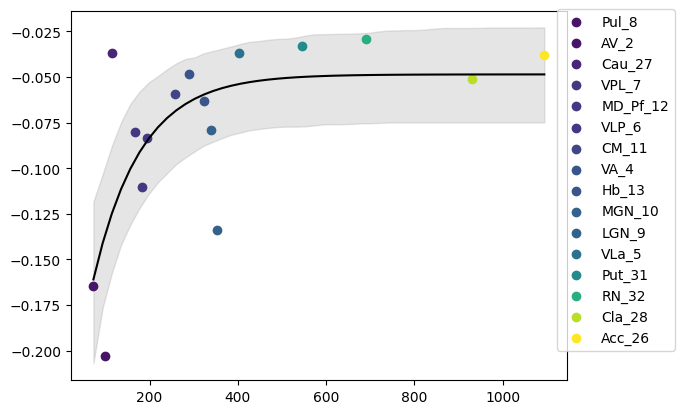

In [81]:
model_data = df.join([df_thomas_left])
model_data = model_data[model_data['dz_type2'] == "MS"]

vols = {}
dists = {}
for struct in structs:
    vols[struct] = []
    formula = f"{struct} ~ {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()

    model_data_mean = model_data[numeric_cols].mean()
    model_data_mean[predictor] = model_data[predictor].mean() - model_data[predictor].std()
    vols[struct].append(res.predict(model_data_mean)[0])

    model_data_mean[predictor] = model_data[predictor].mean() + model_data[predictor].std()
    res.predict(model_data_mean)[0]
    vols[struct].append(res.predict(model_data_mean)[0])

    ind = re.match(r".+_(\d+)$", struct)[1]

    dists[struct] = mni_dists.loc[int(ind), "left_exposure"]

y_data = np.array([(item[1]-item[0])/item[0] for item in vols.values()])
x_data = np.array([item for item in dists.values()])
labels = [item for item in dists.keys()]

popt, pcov = curve_fit(saturation_curve, x_data, y_data, p0=[1, 0, 0])

x_range = np.linspace(x_data.min(), x_data.max(), 50)
y_pred = saturation_curve(x_range, *popt)
y_boots = np.zeros((1000, len(x_range)))
for i in range(1000):
    y_boots[i, :] = saturation_curve(x_range, *all_popt_arr[i])

y_boots = np.sort(y_boots, axis=0)
y_low = y_boots[25, :]
y_high = y_boots[975, :]

plt.fill_between(x_range, y_low, y_high, alpha=0.2, color='gray')


sorted_inds = np.argsort(x_data)

for i in sorted_inds:
    x = x_data[i]
    y = y_data[i]
    lab = labels[i]
    c = x / x_data.max()
    plt.scatter(x, y, label=lab, color=viridis(c))
plt.legend(loc=(0.98, 0.08))
plt.plot(x_range, y_pred, color="black")

#### PMS Patients

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'PMS\n t2lv_logtrans ~ struct + age + Female + tiv'}, xlabel='choroid-sdt dist', ylabel='coef'>)

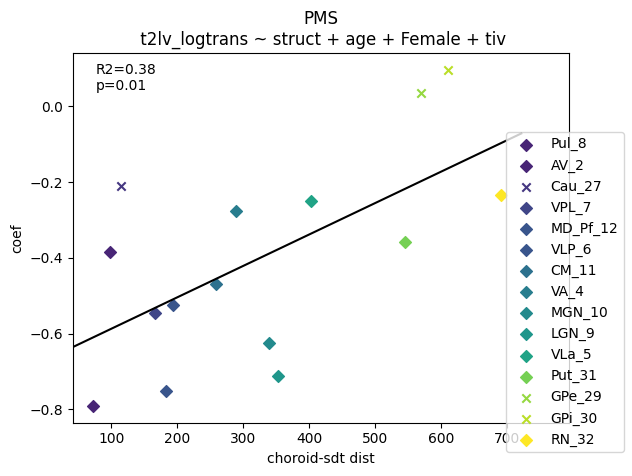

In [148]:
model_data = df_z.join([df_thomas_z])
model_data = model_data[model_data['dz_type5'] == "PMS"]
structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33", "Cla_28", "Acc_26", "Hb_13", "MTT_14"])]

covariates = "age + Female + tiv"
outcome = "t2lv_logtrans"

regression_results = regress_all_nuclei2(model_data, covariates, outcome, structs)

data = regression_results.copy()
# for i in data.index:
#     data.loc[i, 'dist'] = choroid_dists[str(i)].mean()

data['dist'] = mni_dists['left_exposure']


plot_xordered_data(data, "dist", "coef", "struct", fit_line=True,
                   xlabel="choroid-sdt dist", title=f"PMS\n {outcome} ~ struct + {covariates}")

In [41]:
slopes, r_values, p_boot = bootstrap_procedure(model_data, choroid_dists, covariates, outcome, structs)

slopes.sort()
mean_slope = slopes.mean()
print("Slope: {:0.2} [{:0.2}, {:0.2}]".format(mean_slope, slopes[25], slopes[975]))

r_values.sort()
mean_r_value = r_values.mean()
print("R2: {:0.2} [{:0.2}, {:0.2}]".format(mean_r_value**2, r_values[25]**2, r_values[975]**2))

  0%|          | 0/1000 [00:00<?, ?it/s]

Slope: 0.005 [-0.0027, 0.013]
R2: 0.044 [0.02, 0.24]


In [42]:
p_boot

0.106

In [ ]:
df_to_sample = model_data.copy() # copy over the model_data from above
df_to_sample = df_to_sample.reset_index()
df_dists_to_sample = choroid_dists.reset_index()

n_boots = 1000
t_stats = np.zeros((n_boots,))
slopes = np.zeros((n_boots,))
r_values = np.zeros((n_boots,))
for i_samp in tqdm(range(n_boots)):
    inds = np.random.randint(0, df_to_sample.index.max(), len(df_to_sample))
    model_data = df_to_sample.loc[inds, :]
    dists = df_dists_to_sample.loc[inds, :]

    regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)
    data = regression_results.copy()
    for i in data.index:
        data.loc[i, 'dist'] = dists[str(i)].mean()
    slope, intercept, r_value, p_value, std_err = stats.linregress(data['dist'], data['coef'])
    t_stats[i_samp] = (slope / std_err)
    slopes[i_samp] = slope
    r_values[i_samp] = r_value

slopes.sort()
mean_slope = slopes.mean()
print("Slope: {:0.2} [{:0.2}, {:0.2}]".format(mean_slope, slopes[25], slopes[975]))

r_values.sort()
mean_r_value = r_values.mean()
print("R2: {:0.2} [{:0.2}, {:0.2}]".format(mean_r_value**2, r_values[25]**2, r_values[975]**2))

p_boot = sum(t_stats <= 0) / n_boots
print("Bootstrapped p: {:0.2f}".format(p_boot))

  0%|          | 0/1000 [00:00<?, ?it/s]

Slope: 0.018 [0.008, 0.03]
R2: 0.14 [0.034, 0.3]
Bootstrapped p: 0.00


#### OIND Patients

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'NIND\n choroid_volume ~ struct + age + Female + tiv'}, xlabel='choroid-sdt dist', ylabel='coef'>)

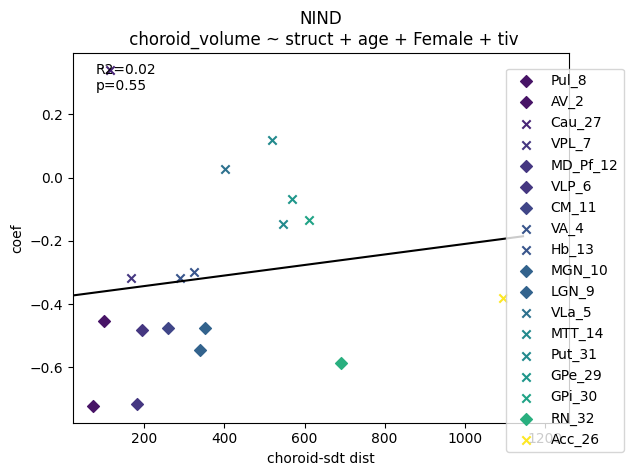

In [ ]:
model_data = df_z.join([df_thomas_z])
model_data = model_data[model_data['dz_type5'] == "OIND"]
structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33", "Cla_28", "MTT"])]
covariates = "age + Female + tiv"
outcome = "choroid_volume"

regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)

data = regression_results.copy()
# for i in data.index:
#     data.loc[i, 'dist'] = choroid_dists[str(i)].mean()

data['dist'] = mni_dists['left_exposure']


plot_xordered_data(data, "dist", "coef", "struct", fit_line=True,
                   xlabel="choroid-sdt dist", title=f"NIND\n {outcome} ~ struct + {covariates}")

In [288]:
df_to_sample = df_z.join([df_thomas_z])
df_to_sample = df_to_sample[df_to_sample['dz_type5'].isin(["OIND"])]
df_to_sample = df_to_sample.reset_index()
df_dists_to_sample = choroid_dists.reset_index()

n_boots = 1000
t_stats_oind = np.zeros((n_boots,))
slopes_oind = np.zeros((n_boots,))
r_values_oind = np.zeros((n_boots,))
for i_samp in tqdm(range(n_boots)):
    inds = np.random.randint(0, df_to_sample.index.max(), len(df_to_sample))
    model_data = df_to_sample.loc[inds, :]
    dists = df_dists_to_sample.loc[inds, :]

    regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)
    data = regression_results.copy()
    for i in data.index:
        data.loc[i, 'dist'] = dists[str(i)].mean()
    slope, intercept, r_value, p_value, std_err = stats.linregress(data['dist'], data['coef'])
    t_stats_oind[i_samp] = (slope / std_err)
    slopes_oind[i_samp] = slope
    r_values_oind[i_samp] = r_value

slopes_oind.sort()
mean_slope = slopes_oind.mean()
print("Slope: {:0.2} [{:0.2}, {:0.2}]".format(mean_slope, slopes_oind[25], slopes_oind[975]))

r_values_oind.sort()
mean_r_value = r_values_oind.mean()
print("R2: {:0.2} [{:0.2}, {:0.2}]".format(mean_r_value**2, r_values_oind[25]**2, r_values_oind[975]**2))

p_boot = sum(t_stats_oind <= 0) / n_boots
print("Bootstrapped p: {:0.2f}".format(p_boot))

  0%|          | 0/1000 [00:00<?, ?it/s]

Slope: 0.0049 [-0.014, 0.022]
R2: 4.5e-05 [0.4, 0.16]
Bootstrapped p: 0.35


### Do it with cortical thickness and t2lv

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'MS\n struct ~ *t2lv* + age + Female + tiv + choroid_volume'}, xlabel='ventricle-sdt dist', ylabel='coef'>)

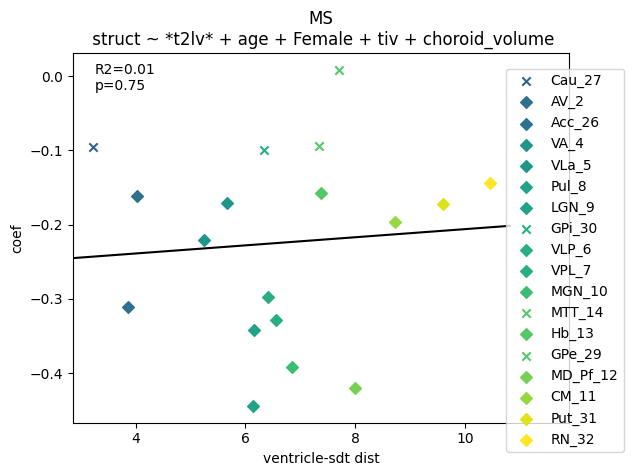

In [52]:
model_data = df_z.join([df_thomas_z])
model_data = model_data[model_data['dz_type2'] == "MS"]
structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33", "Cla_28"])]
covariates = "age + Female + tiv + choroid_volume"
outcome = "t2lv"

regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)

data = regression_results.copy()
for i in data.index:
    data.loc[i, 'dist'] = ventricle_dists[str(i)].mean()

plot_xordered_data(data, "dist", "coef", "struct", fit_line=True,
                   xlabel="ventricle-sdt dist", title=f"MS\n struct ~ *{outcome}* + {covariates}")

In [46]:
slopes, r_values, p_boot = bootstrap_procedure(model_data, choroid_dists, covariates, outcome, structs)

slopes.sort()
mean_slope = slopes.mean()
print("Slope: {:0.2} [{:0.2}, {:0.2}]".format(mean_slope, slopes[25], slopes[975]))

r_values.sort()
mean_r_value = r_values.mean()
print("R2: {:0.2} [{:0.2}, {:0.2}]".format(mean_r_value**2, r_values[25]**2, r_values[975]**2))

print(p_boot)

  0%|          | 0/1000 [00:00<?, ?it/s]

Slope: 0.014 [0.008, 0.021]
R2: 0.24 [0.11, 0.4]
0.0


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'MS\n struct ~ *cortical_thickness* + age + Female + tiv + choroid_volume'}, xlabel='choroid-sdt dist', ylabel='coef'>)

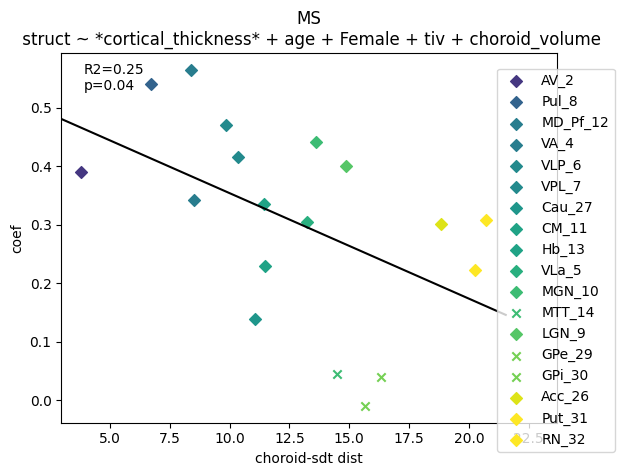

In [47]:
model_data = df_z.join([df_thomas_z])
model_data = model_data[model_data['dz_type2'] == "MS"]
structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33", "Cla_28"])]
covariates = "age + Female + tiv + choroid_volume"
outcome = "cortical_thickness"

regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)

data = regression_results.copy()
for i in data.index:
    data.loc[i, 'dist'] = choroid_dists[str(i)].mean()

plot_xordered_data(data, "dist", "coef", "struct", fit_line=True,
                   xlabel="choroid-sdt dist", title=f"MS\n struct ~ *{outcome}* + {covariates}")

In [48]:
slopes, r_values, p_boot = bootstrap_procedure(model_data, choroid_dists, covariates, outcome, structs)

slopes.sort()
mean_slope = slopes.mean()
print("Slope: {:0.2} [{:0.2}, {:0.2}]".format(mean_slope, slopes[25], slopes[975]))

r_values.sort()
mean_r_value = r_values.mean()
print("R2: {:0.2} [{:0.2}, {:0.2}]".format(mean_r_value**2, r_values[25]**2, r_values[975]**2))

print(p_boot)

  0%|          | 0/1000 [00:00<?, ?it/s]

Slope: -0.016 [-0.022, -0.01]
R2: 0.2 [0.32, 0.1]
1.0


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'MS\n struct ~ *EDSS_sqrt* + age + Female + tiv + choroid_volume'}, xlabel='choroid-sdt dist', ylabel='coef'>)

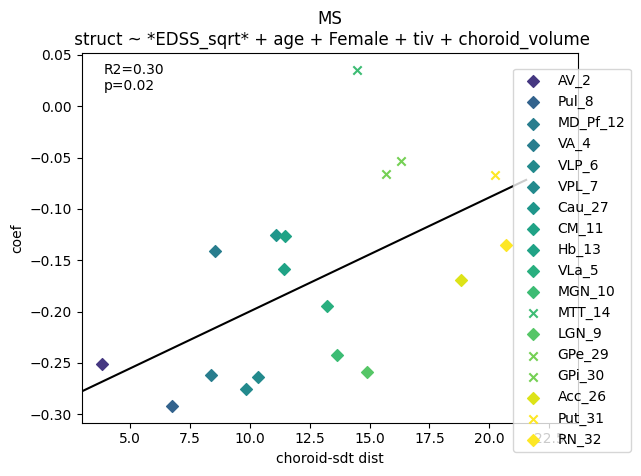

In [49]:
model_data = df_z.join([df_thomas_z])
model_data = model_data[model_data['dz_type2'] == "MS"]
structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33", "Cla_28"])]
covariates = "age + Female + tiv + choroid_volume"
outcome = "EDSS_sqrt"

regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)

data = regression_results.copy()
for i in data.index:
    data.loc[i, 'dist'] = choroid_dists[str(i)].mean()

plot_xordered_data(data, "dist", "coef", "struct", fit_line=True,
                   xlabel="choroid-sdt dist", title=f"MS\n struct ~ *{outcome}* + {covariates}")

In [50]:
slopes, r_values, p_boot = bootstrap_procedure(model_data, choroid_dists, covariates, outcome, structs)

slopes.sort()
mean_slope = slopes.mean()
print("Slope: {:0.2} [{:0.2}, {:0.2}]".format(mean_slope, slopes[25], slopes[975]))

r_values.sort()
mean_r_value = r_values.mean()
print("R2: {:0.2} [{:0.2}, {:0.2}]".format(mean_r_value**2, r_values[25]**2, r_values[975]**2))

print(p_boot)

  0%|          | 0/1000 [00:00<?, ?it/s]

Slope: 0.011 [0.0052, 0.017]
R2: 0.25 [0.094, 0.45]
0.0


### Thalamic Nuclei

#### MS Patients

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'MS Patients\n CP ~ struct + age + Female + tiv'}, xlabel='choroid-sdt dist', ylabel='coef'>)

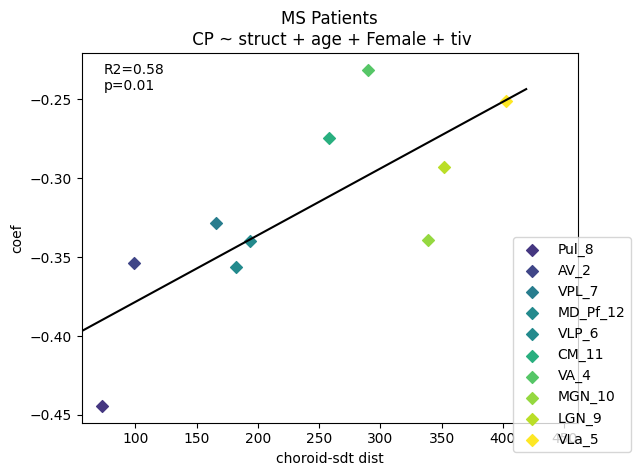

In [88]:
model_data = df_z.join([df_thomas_z])
model_data = model_data[model_data['dz_type2'] == "MS"]
structs = hips_thomas_ref[thalamic_nuclei]
covariates = "age + Female + tiv"
outcome = "PRL"

regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)

data = regression_results.copy()
# for i in data.index:
#     data.loc[i, 'dist'] = choroid_dists[str(i)].mean()
#     # data.loc[i, 'dist'] = mni_choroid_dists.loc[0, str(i)]
data['dist'] = mni_dists['left_exposure']


plot_xordered_data(data, "dist", "coef", "struct", fit_line=True,
                   xlabel="choroid-sdt dist", title=f"MS Patients\n CP ~ struct + {covariates}")

Bootstrap

In [38]:
df_to_sample = df_z.join([df_thomas_z])
df_to_sample = df_to_sample[df_to_sample['dz_type2'].isin(["MS"])]
df_to_sample = df_to_sample.reset_index()
df_dists_to_sample = choroid_dists.reset_index()
dists = mni_dists['left_exposure']

n_boots = 1000
t_stats_ms = np.zeros((n_boots,))
slopes_ms = np.zeros((n_boots,))
r_values_ms = np.zeros((n_boots,))
for i_samp in tqdm(range(n_boots)):
    inds = np.random.randint(0, df_to_sample.index.max(), len(df_to_sample))
    model_data = df_to_sample.loc[inds, :]
    # dists = df_dists_to_sample.loc[inds, :]

    regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)
    data = regression_results.copy()
    data['dist'] = mni_dists['left_exposure']
    # for i in data.index:
    #     data.loc[i, 'dist'] = dists[str(i)].mean()
    slope, intercept, r_value, p_value, std_err = stats.linregress(data['dist'], data['coef'])
    t_stats_ms[i_samp] = (slope / std_err)
    slopes_ms[i_samp] = slope
    r_values_ms[i_samp]  = r_value

slopes_ms.sort()
mean_slope = slopes_ms.mean()
print("Slope: {:0.2} [{:0.2}, {:0.2}]".format(mean_slope, slopes_ms[25], slopes_ms[975]))

r_values_ms.sort()
mean_r_value = r_values_ms.mean()
print("R2: {:0.2} [{:0.2}, {:0.2}]".format(mean_r_value**2, r_values_ms[25]**2, r_values_ms[975]**2))

p_boot = sum(t_stats_ms <= 0) / n_boots
print("Bootstrapped p: {:0.2f}".format(p_boot))

  0%|          | 0/1000 [00:00<?, ?it/s]

Slope: 0.00053 [0.0003, 0.00076]
R2: 0.31 [0.13, 0.51]
Bootstrapped p: 0.00


#### PMS Patients

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'PMS Patients\n CP ~ struct + age + Female + tiv'}, xlabel='choroid-sdt dist', ylabel='coef'>)

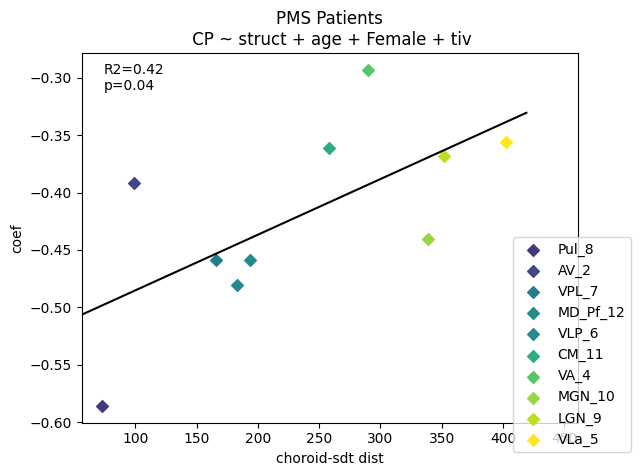

In [97]:
model_data = df_z.join([df_thomas_z])
model_data = model_data[model_data['dz_type5'].isin(["RMS"])]
structs = hips_thomas_ref[thalamic_nuclei]
covariates = "age + Female + tiv"
outcome = "PRL"

regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)

data = regression_results.copy()
# for i in data.index:
#     data.loc[i, 'dist'] = choroid_dists[str(i)].mean()

data['dist'] = mni_dists['left_exposure']


plot_xordered_data(data, "dist", "coef", "struct", fit_line=True,
                   xlabel="choroid-sdt dist", title=f"PMS Patients\n CP ~ struct + {covariates}")

PMS

In [ ]:
df_to_sample = model_data.copy() # copy over the model_data from above
df_to_sample = df_to_sample.reset_index()
df_dists_to_sample = choroid_dists.reset_index()

n_boots = 1000
t_stats = np.zeros((n_boots,))
slopes = np.zeros((n_boots,))
r_values = np.zeros((n_boots,))
for i_samp in tqdm(range(n_boots)):
    inds = np.random.randint(0, df_to_sample.index.max(), len(df_to_sample))
    model_data = df_to_sample.loc[inds, :]
    dists = df_dists_to_sample.loc[inds, :]

    regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)
    data = regression_results.copy()
    for i in data.index:
        data.loc[i, 'dist'] = dists[str(i)].mean()
    slope, intercept, r_value, p_value, std_err = stats.linregress(data['dist'], data['coef'])
    t_stats[i_samp] = (slope / std_err)
    slopes[i_samp] = slope
    r_values[i_samp] = r_value

slopes.sort()
mean_slope = slopes.mean()
print("Slope: {:0.2} [{:0.2}, {:0.2}]".format(mean_slope, slopes[25], slopes[975]))

r_values.sort()
mean_r_value = r_values.mean()
print("R2: {:0.2} [{:0.2}, {:0.2}]".format(mean_r_value**2, r_values[25]**2, r_values[975]**2))

p_boot = sum(t_stats <= 0) / n_boots
print("Bootstrapped p: {:0.2f}".format(p_boot))

  0%|          | 0/1000 [00:00<?, ?it/s]

Slope: 0.0063 [-0.0058, 0.02]
R2: 0.088 [0.075, 0.59]
Bootstrapped p: 0.14


#### OIND Patients

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'OIND\n CP ~ struct + age + Female + tiv'}, xlabel='choroid-sdt dist', ylabel='coef'>)

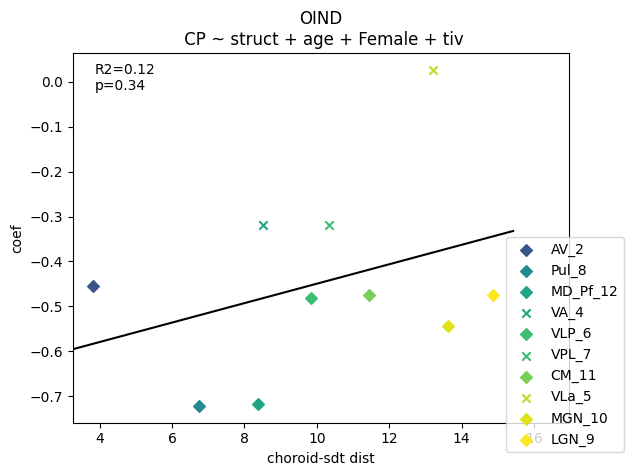

In [145]:
model_data = df_z.join([df_thomas_z])
model_data = model_data[model_data['dz_type5'] == "OIND"]
structs = hips_thomas_ref.loc[thalamic_nuclei, 'struct_name']
covariates = "age + Female + tiv"
outcome = "choroid_volume"

regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)

data = regression_results.copy()
for i in data.index:
    data.loc[i, 'dist'] = choroid_dists[str(i)].mean()

plot_xordered_data(data, "dist", "coef", "struct", fit_line=True,
                   xlabel="choroid-sdt dist", title=f"OIND\n CP ~ struct + {covariates}")

In [146]:
df_to_sample = df_z.join([df_thomas_z])
df_to_sample = df_to_sample[df_to_sample['dz_type5'].isin(["OIND"])]
df_to_sample = df_to_sample.reset_index()
df_dists_to_sample = choroid_dists.reset_index()

n_boots = 1000
t_stats_oind = np.zeros((n_boots,))
slopes_oind = np.zeros((n_boots,))
r_values_oind = np.zeros((n_boots,))
for i_samp in tqdm(range(n_boots)):
    inds = np.random.randint(0, df_to_sample.index.max(), len(df_to_sample))
    model_data = df_to_sample.loc[inds, :]
    dists = df_dists_to_sample.loc[inds, :]

    regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)
    data = regression_results.copy()
    for i in data.index:
        data.loc[i, 'dist'] = dists[str(i)].mean()
    slope, intercept, r_value, p_value, std_err = stats.linregress(data['dist'], data['coef'])
    t_stats_oind[i_samp] = (slope / std_err)
    slopes_oind[i_samp] = slope
    r_values_oind[i_samp] = r_value

slopes_oind.sort()
mean_slope = slopes_oind.mean()
print("Slope: {:0.2} [{:0.2}, {:0.2}]".format(mean_slope, slopes_oind[25], slopes_oind[975]))

r_values_oind.sort()
mean_r_value = r_values_oind.mean()
print("R2: {:0.2} [{:0.2}, {:0.2}]".format(mean_r_value**2, r_values_oind[25]**2, r_values_oind[975]**2))

p_boot = sum(t_stats_oind <= 0) / n_boots
print("Bootstrapped p: {:0.2f}".format(p_boot))

  0%|          | 0/1000 [00:00<?, ?it/s]

Slope: 0.032 [-0.0025, 0.078]
R2: 0.12 [0.0022, 0.47]
Bootstrapped p: 0.04


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'MS\n struct ~ cp*t2lv + age + Female + tiv'}, xlabel='choroid-sdt dist', ylabel='coef'>)

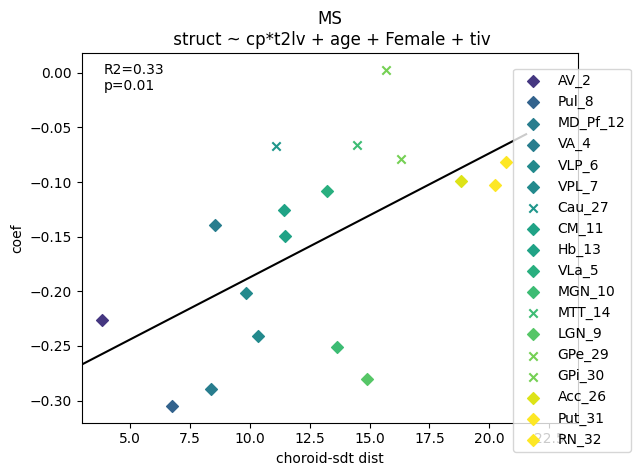

In [13]:
model_data = df_z.join([df_thomas_z])
model_data = model_data[model_data['dz_type2'] == "MS"]
structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33", "Cla_28"])]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}
se = {}

if len(covariates) > 0:
    plus_covariates = f"+ {covariates}"
else:
    plus_covariates = ""
all_results = {}
for struct in structs:
    formula = f"{struct} ~ choroid_volume + t2lv {plus_covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[struct] = res.pvalues["t2lv"]
    coefs[struct] = res.params["t2lv"]
    se[struct] = res.HC0_se["t2lv"]
    all_results[struct] = res

regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals, "se": se})
regression_results['p_fdr'] = stats.false_discovery_control(
    regression_results['pvals'], method='bh'
)
# regression_results = regression_results.sort_values(by="coef", ascending=True)
regression_results.insert(0, "struct", regression_results.index)
new_index = []
for item in regression_results.struct:
    new_index.append(int(re.match(r".+_(\d+)$", item)[1]))

for i, row in regression_results.iterrows():
    if row['p_fdr'] < 0.05:
        regression_results.loc[i, 'coef_sig'] = row['coef']
    else:
        regression_results.loc[i, 'coef_sig'] = 0

regression_results.index = new_index

data = regression_results.copy()
for i in data.index:
    data.loc[i, 'dist'] = choroid_dists[str(i)].mean()
    # data.loc[i, 'dist'] = mni_choroid_dists.loc[0, str(i)]

plot_xordered_data(data, "dist", "coef", "struct", fit_line=True,
                   xlabel="choroid-sdt dist", title=f"MS\n struct ~ cp*t2lv + {covariates}")

In [81]:
from pyprocessmacro import Process

model_data = df_z.join([df_thomas_left_z])
model_data = model_data[model_data['dz_type2'] == "MS"]

p2 = Process(data=model_data, model=8, x="t2lv", y="EDSS", w="choroid_volume",
            m=["thalamus"],
            controls=["age", "Female", "tiv"],
            controls_in="all")
p2.summary()

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:1567: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  grad = eval_expression(


Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 8

Variables:
    Cons = Cons
    x = t2lv
    y = EDSS
    w = choroid_volume
    m1 = thalamus
Statistical Controls:
 age, Female, tiv



Sample size:
468

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = EDSS 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2645   0.2512 0.7721 22.7127    7  442   0.0000

Coefficients

                      coeff     se       t      p    LLCI    ULCI
Cons                -0.0384 0.0436 -0.8809 0.3788 -0.1240  0.0471
t2lv                 0.0181 0.0455  0.3974 0.6913 -0.0712  0.1074
choroid_volume      -0.0562 0.0506 -1.1093 0.2679 -0.1554  0.0431
t2lv*choro

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:738: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  expr_x_to_m = eval_expression(der_x_to_m, mod_dict)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:739: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  expr_m_to_y = eval_expression(der_m_to_y, mod_dict)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:752: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  llci, ulci = bias_corrected_ci(e, be, conf)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmac

In [87]:
from pyprocessmacro import Process

model_data = df_z.join([df_thomas_left_z])
model_data = model_data[model_data['dz_type2'] == "MS"]

p2 = Process(data=model_data, model=1, x="t2lv_logtrans", y="EDSS_sqrt", m="choroid_volume",
            controls=["age", "Female", "tiv"],
            controls_in="all")
p2.summary()

Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 1

Variables:
    Cons = Cons
    x = t2lv_logtrans
    y = EDSS_sqrt
    m = choroid_volume
Statistical Controls:
 age, Female, tiv



Sample size:
468

***************************** OUTCOME MODELS ****************************

Outcome = EDSS_sqrt 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2411   0.2291 0.7878 23.4561    6  443   0.0000

Coefficients

                               coeff     se       t      p    LLCI    ULCI
Cons                         -0.0416 0.0454 -0.9166 0.3599 -0.1306  0.0474
t2lv_logtrans                 0.1351 0.0479  2.8193 0.0050  0.0412  0.2290
choroid_volume                0.0220 0.0497  0.4425 0.6584 -0.0754  0.1194
t2lv_logtrans*choroid_volume  0.0730 0.0420  1.7393 0.0827 -0.0093  0.1552
age                           0.4051 0.0466 

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:1567: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  grad = eval_expression(
